import required libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Use Seaborn's context settings to make fonts larger.
import seaborn as sns
sns.set_context('talk')

generate csv for static trace experiments run on different cluster specs ({5,5,10},{5,10,5},{10,5,5})

In [2]:
raw_log_path = "/home/piyush/rp/work/logs3/"
cluster_specs = os.listdir(raw_log_path)
output_file = "static_trace.csv"
append_to_file = False

if os.path.exists(output_file):
    append_to_file = True

with open(output_file, 'a') as output_file:
    #workaround, since can't store all simulation logs at the same time due to space issues
    if append_to_file:
        output_file.seek(0,2)
    else:
        output_file.write("cluster_spec,policy,seed,total_jobs,utilization,average_completion_time,total_completion_time\n")

    for cluster_spec in cluster_specs:
        worker_type = [worker.split("=")[0] for worker in cluster_spec.split(".")]
        worker_count = [worker.split("=")[1] for worker in cluster_spec.split(".")]        

        policies = os.listdir(raw_log_path + cluster_spec + "/")
        for policy in policies:

            seeds = os.listdir(raw_log_path + cluster_spec + "/" + policy)
            for seed in seeds:
                
                for file in os.listdir(raw_log_path + cluster_spec + "/" + policy + "/" + seed):
                    num_jobs = file.split(".")[0].split("=")[1].strip()

                    output_file.write(cluster_spec)
                    output_file.write(",")
                    output_file.write(policy)
                    output_file.write(",")
                    output_file.write(seed.split("=")[1].strip())
                    output_file.write(",")
                    output_file.write(num_jobs)
                    output_file.write(",")
                    
                    with open(raw_log_path + cluster_spec + "/" + policy + "/" + seed + "/" + file, 'r') as log_file:
                        lines = log_file.readlines()
                        index = len(lines)

                        #cluster utilization
                        index = index - 2
                        cluster_utilization = lines[index].strip()
                        output_file.write(cluster_utilization.split(":")[1].strip())
                        output_file.write(",")

                        #Average job completion time
                        index = index - 2
                        avg_job_completion_time = lines[index].strip()
                        output_file.write(avg_job_completion_time.split(":")[1].strip())
                        output_file.write(",")

                        #total duration for all jobs
                        index -= int(num_jobs)
                        total_job_completion_time = lines[index - 2].strip()
                        output_file.write(total_job_completion_time.split(":")[1].strip())
                        
                        output_file.write("\n")

create data frame

In [2]:
csv_path = 'static_trace.csv'
df_static = pd.read_csv(csv_path)

cluster utilization based on cluster spec for each policy with varying lambda values averaged over seeds

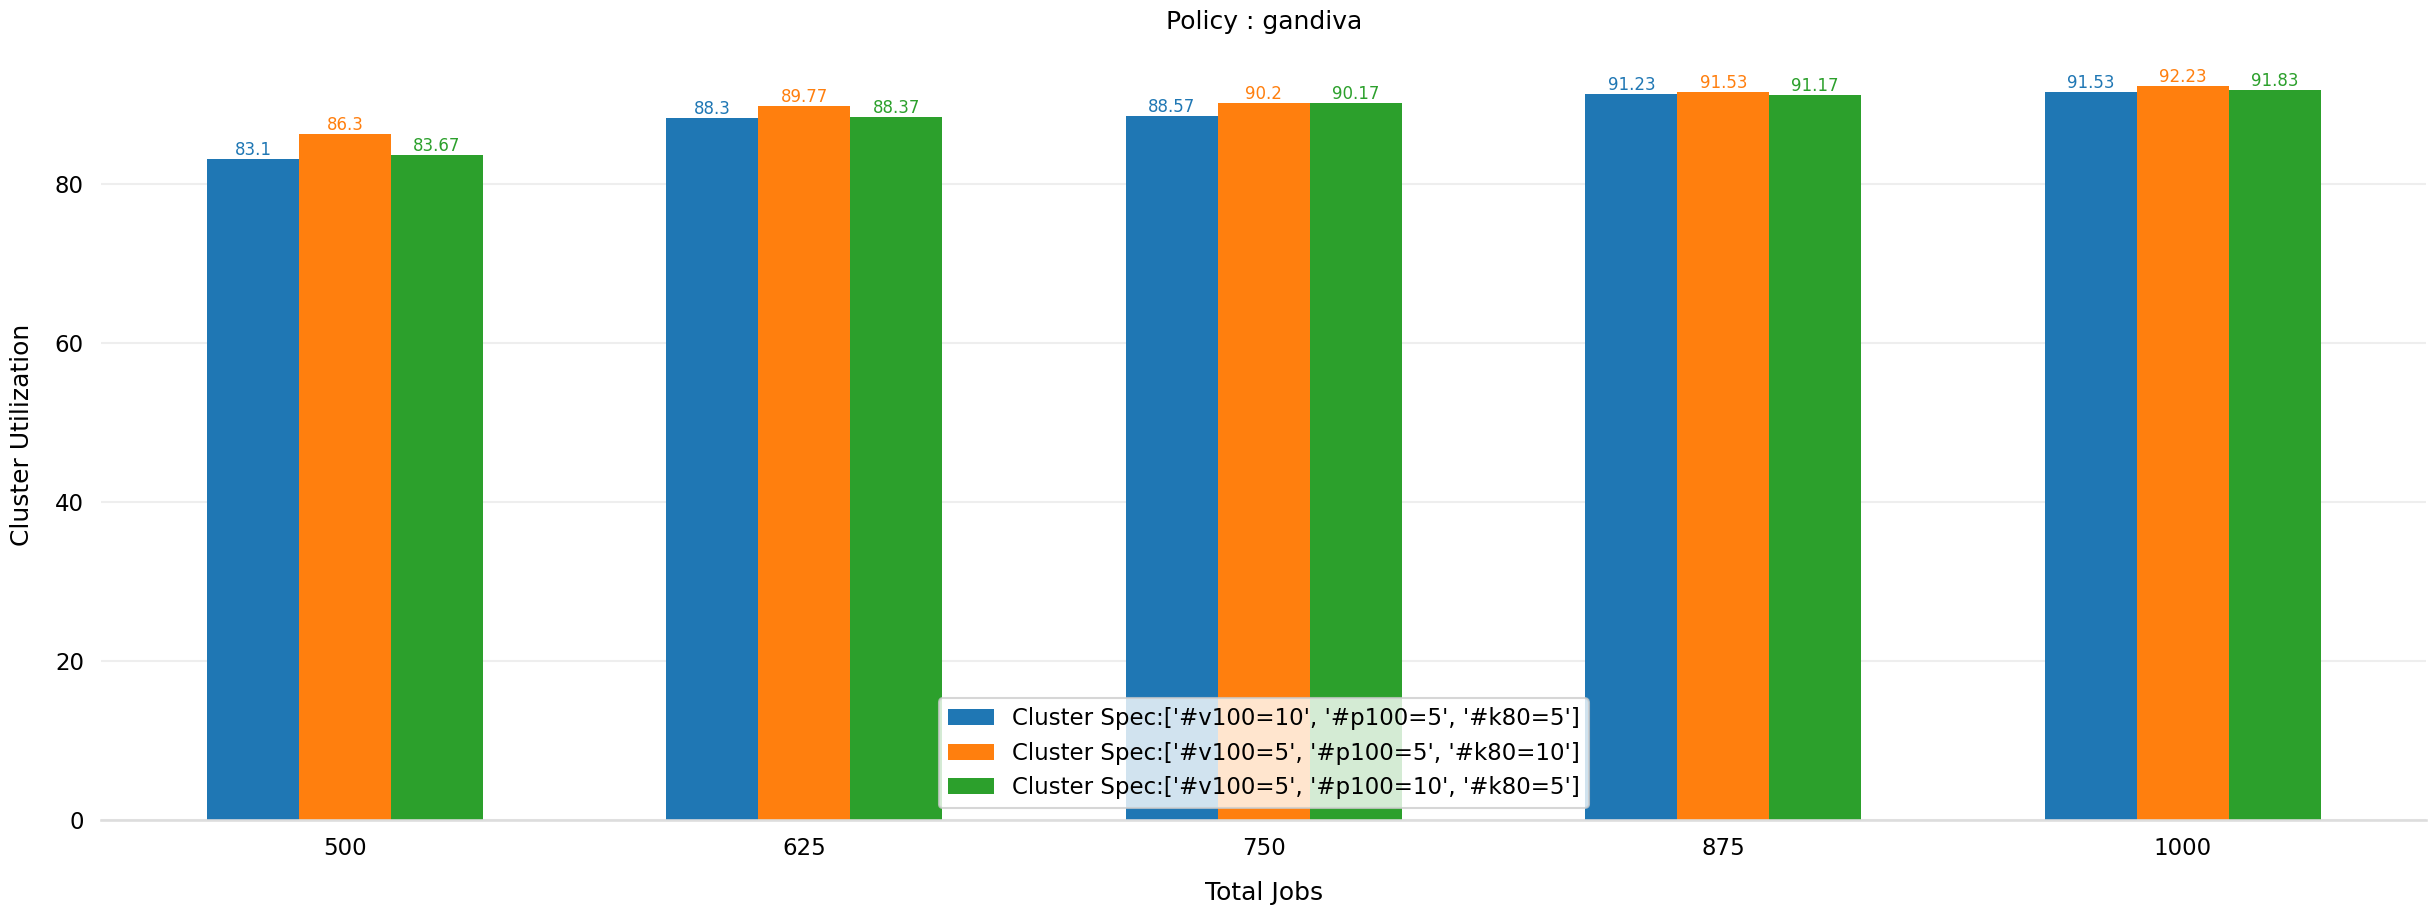

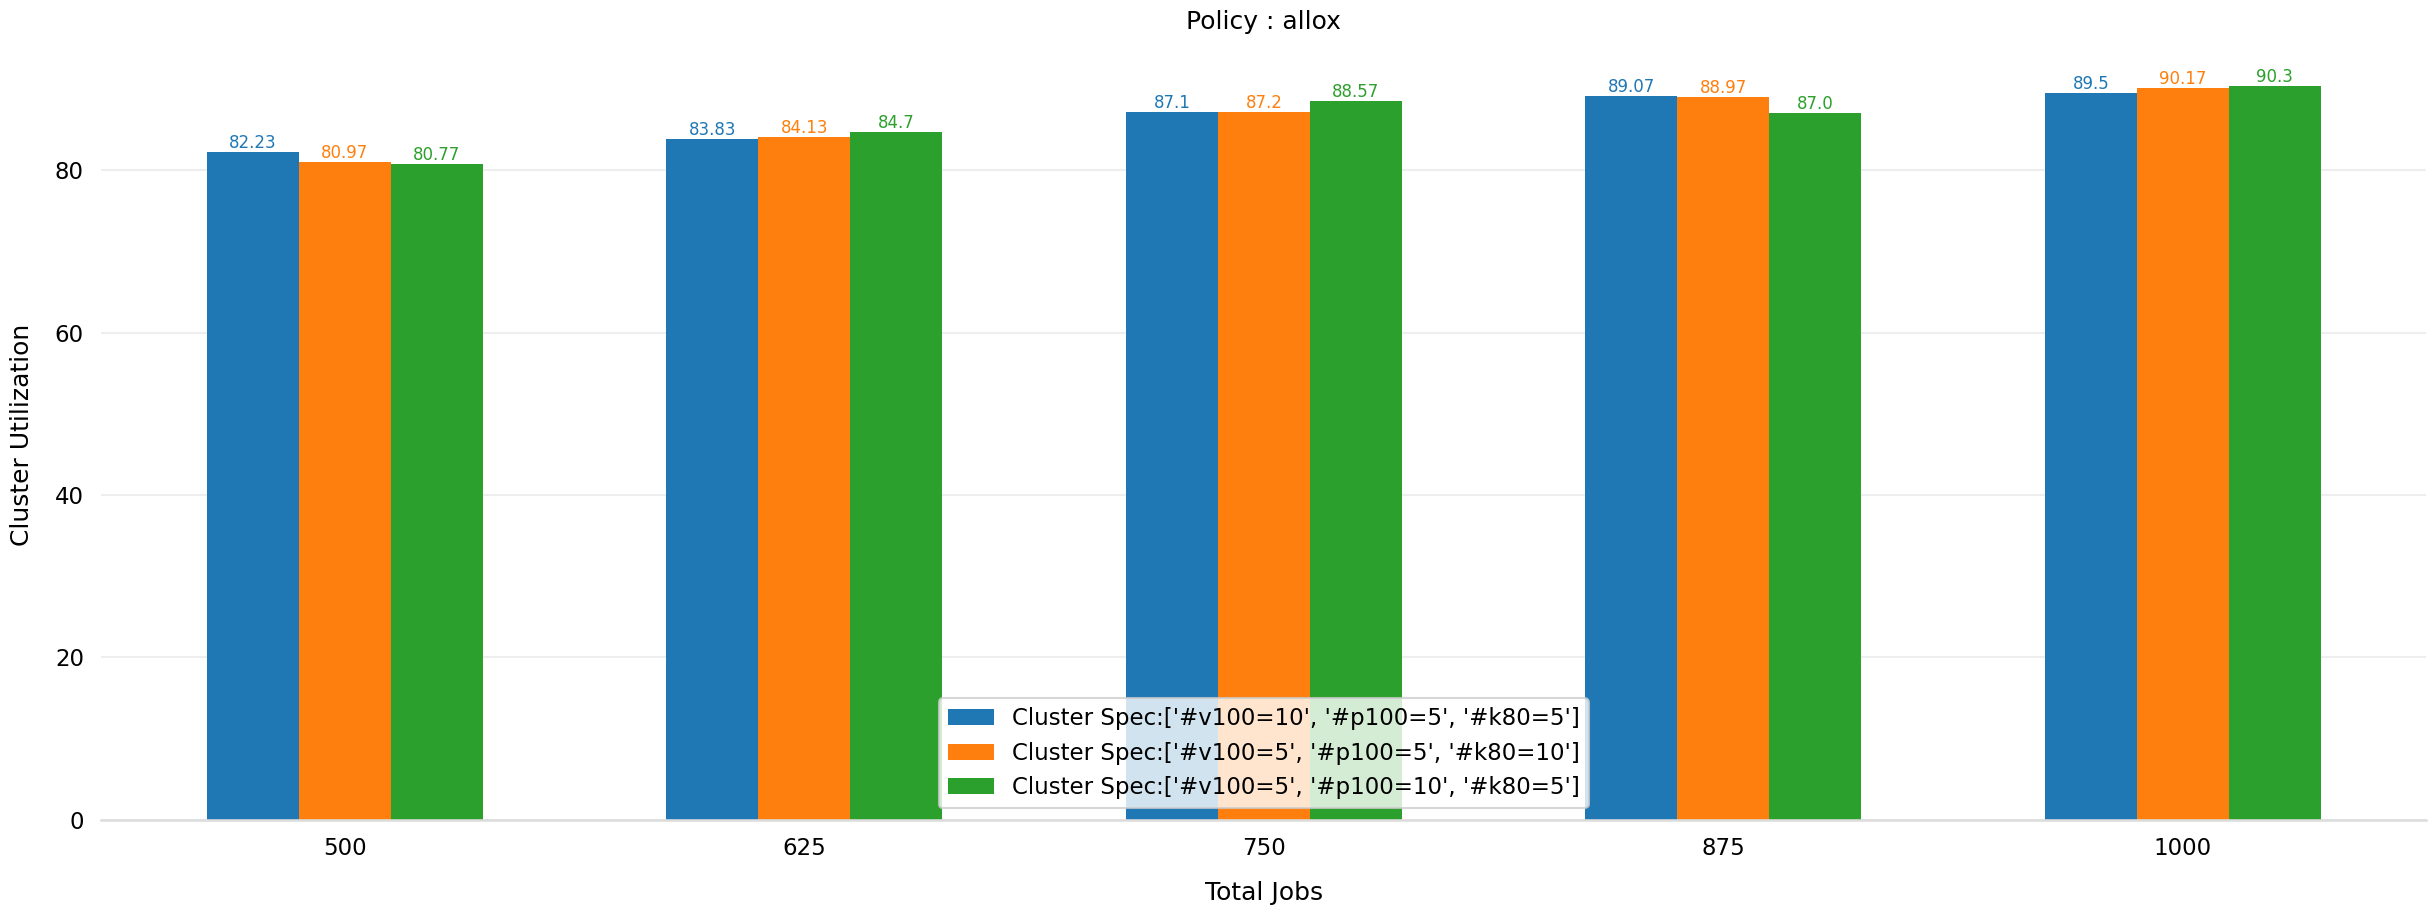

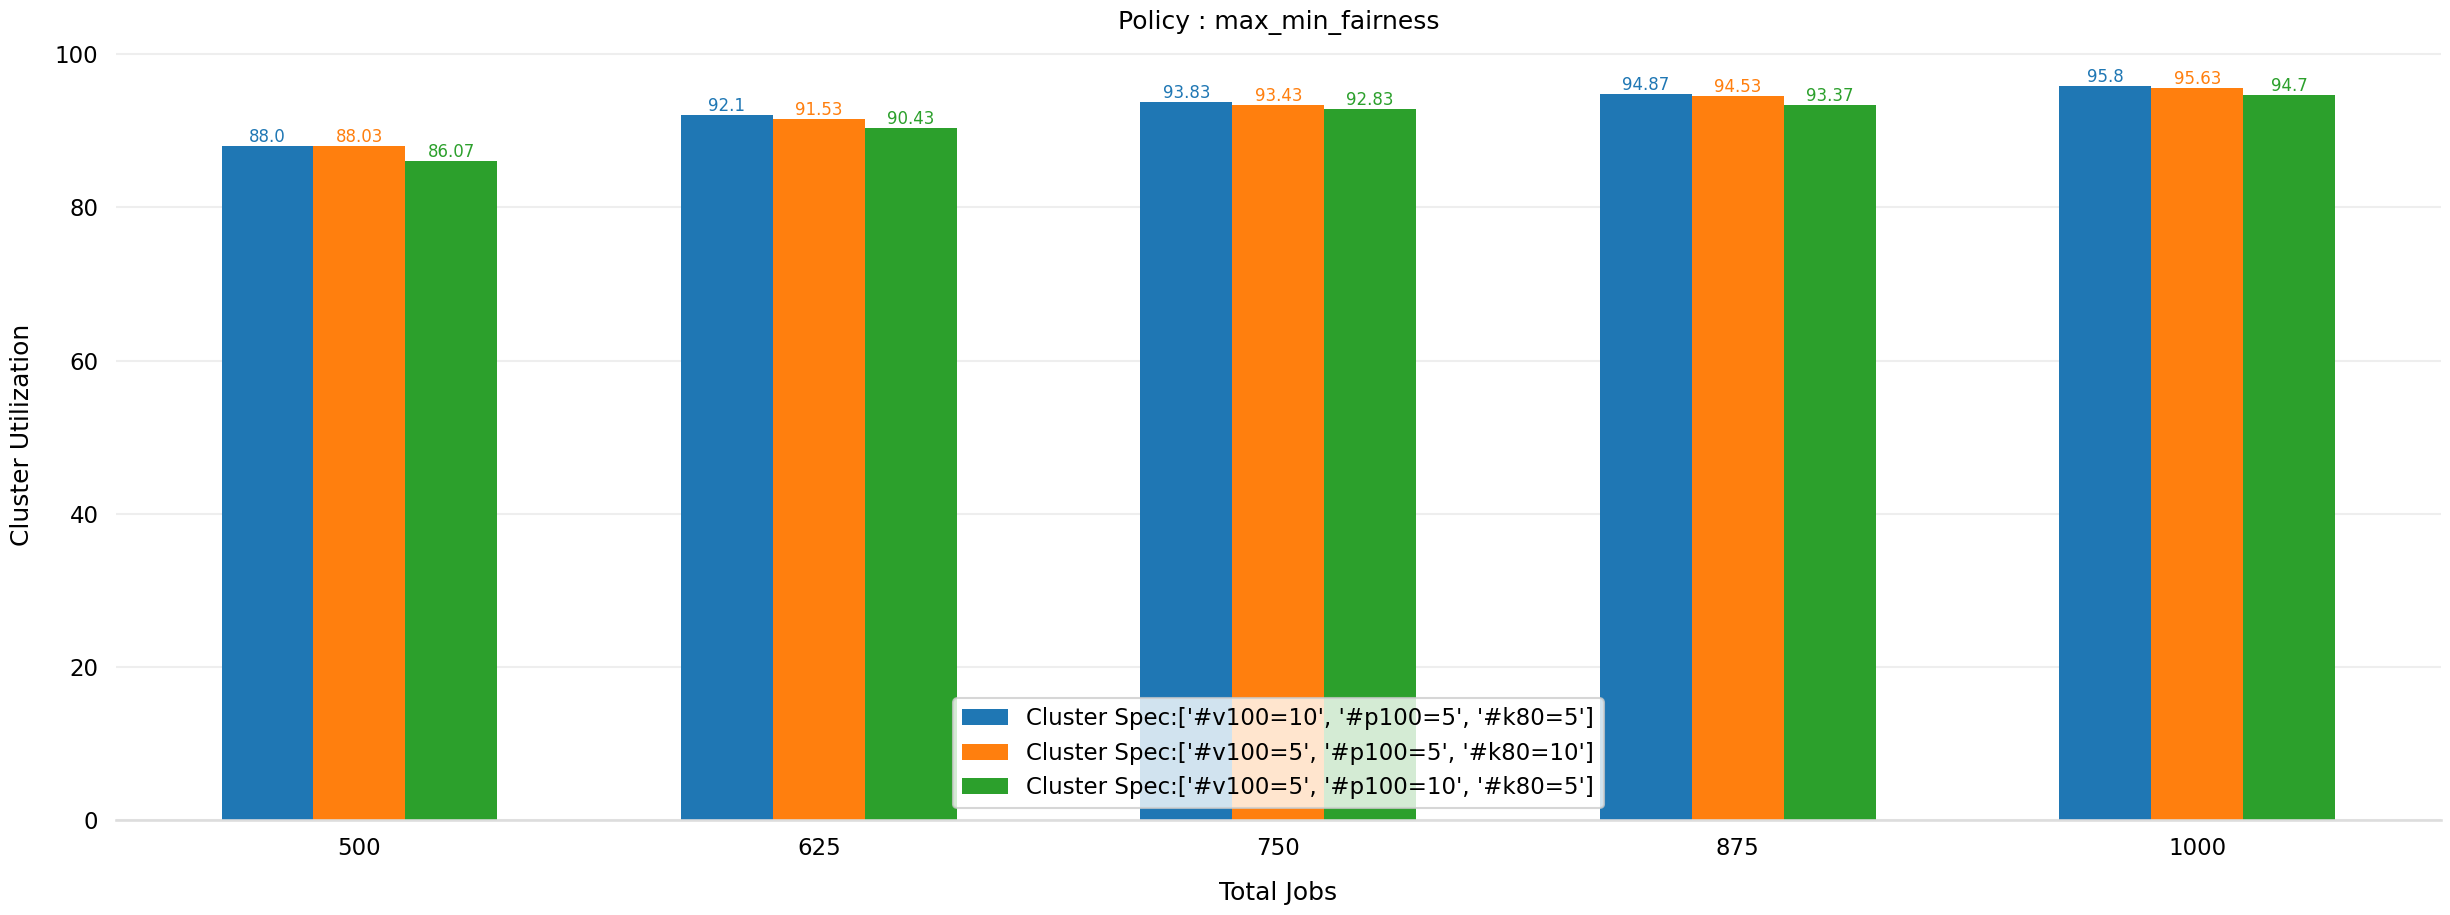

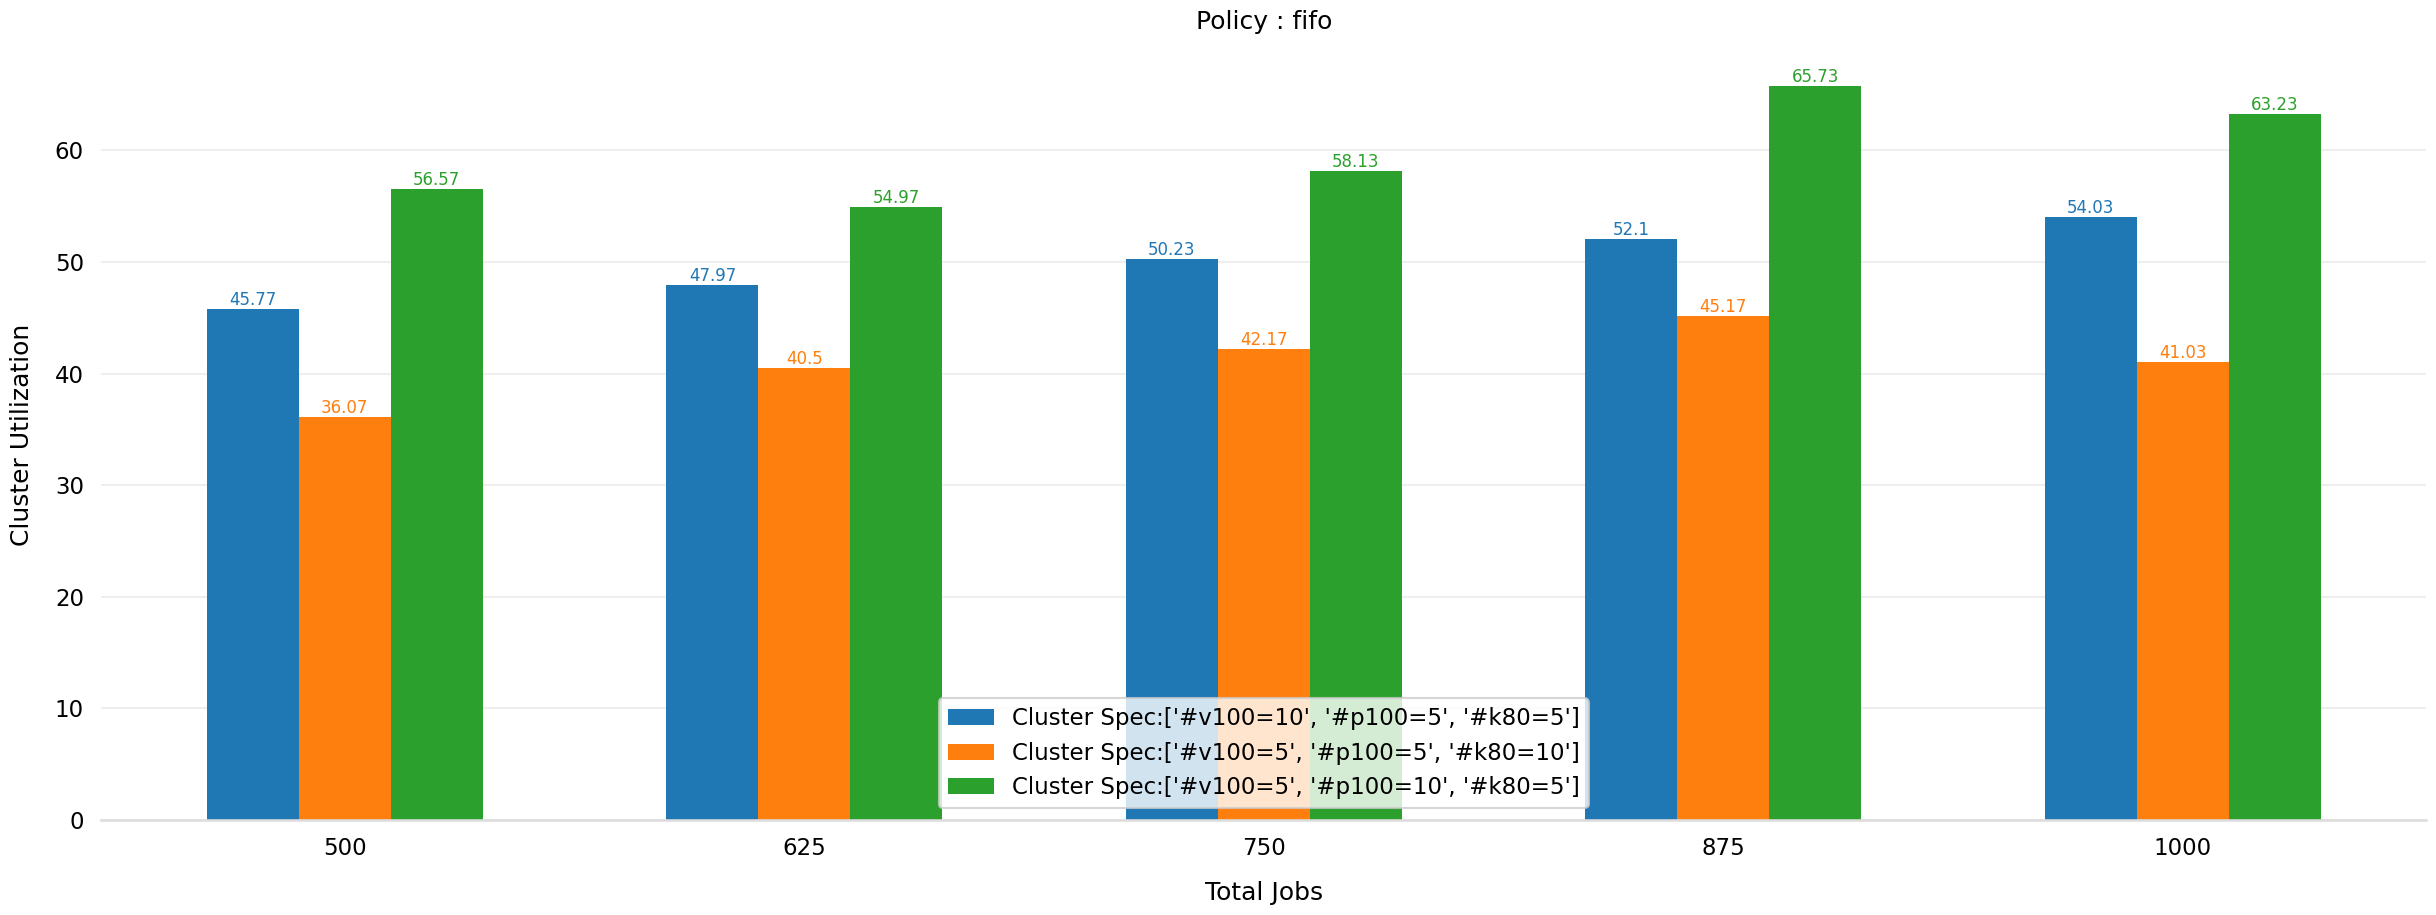

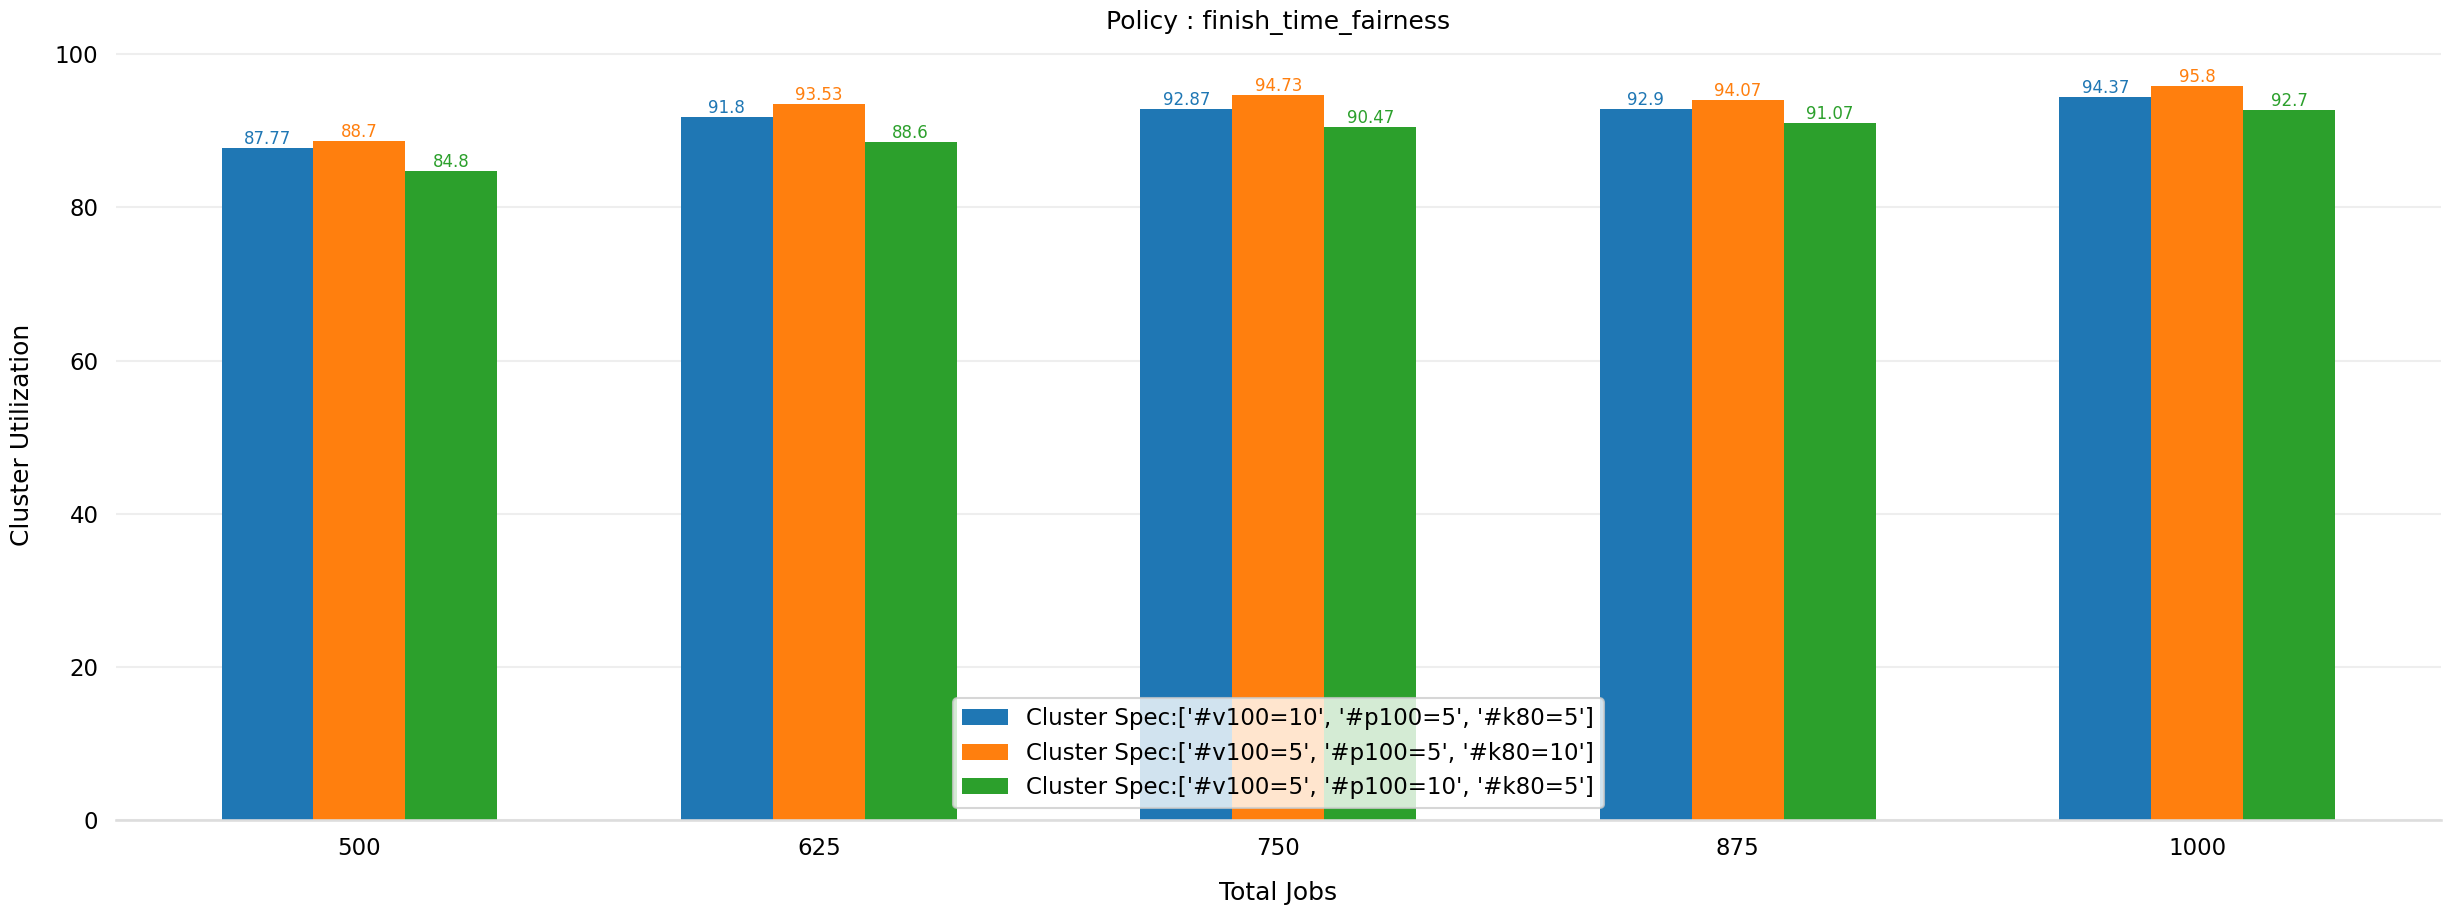

In [3]:
for policy in df_static["policy"].unique():
    result_int = df_static.query(f'policy == "{policy}"')
    
    no_graphs = len(result_int["cluster_spec"].unique())
    fig, ax = plt.subplots(figsize=(30,10))
    bar_width = 0.2

    for idx, cluster_spec in enumerate(result_int["cluster_spec"].unique()):
        result_int2 = result_int.query(f'cluster_spec == "{cluster_spec}"')
        utilization = []

        for lam in result_int2["total_jobs"].unique():
            result_int3 = result_int2[result_int2["total_jobs"] == lam]
            utilization.append((lam, cluster_spec, round(float(result_int3["utilization"].mean() * 100),2)))
        
        utilization.sort()

        x = np.arange(len(utilization))
        y = [x[2] for x in utilization]

        x_labels = [x[0] for x in utilization]

        cluster_details = cluster_spec.split(".")
        cluster_details = [f'#{l}' for l in cluster_details]
        ax.bar(x + (bar_width * idx), y, width=bar_width,label=f'Cluster Spec:{cluster_details}')
        ax.set_xticks(x + (no_graphs - 1) * (bar_width / 2))
        ax.set_xticklabels(x_labels)
        
    ax.legend(loc ="lower center")

    ax.set_xlabel('Total Jobs', labelpad=15)
    ax.set_ylabel('Cluster Utilization', labelpad=15)
    ax.set_title(f'Policy : {policy}', pad=15)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)

    # For each bar in the chart, add a text label.
    for bar in ax.patches:
    # The text annotation for each bar should be its height.
        bar_value = bar.get_height()
        # Format the text with commas to separate thousands. You can do
        # any type of formatting here though.
        text = f'{bar_value:,}'
        # This will give the middle of each bar on the x-axis.
        text_x = bar.get_x() + bar.get_width() / 2
        # get_y() is where the bar starts so we add the height to it.
        text_y = bar.get_y() + bar_value
        # If we want the text to be the same color as the bar, we can
        # get the color like so:
        bar_color = bar.get_facecolor()
        # If you want a consistent color, you can just set it as a constant, e.g. #222222
        ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
                size=12)

average completion time based on cluster spec for each policy with varying lambda values averaged over seeds

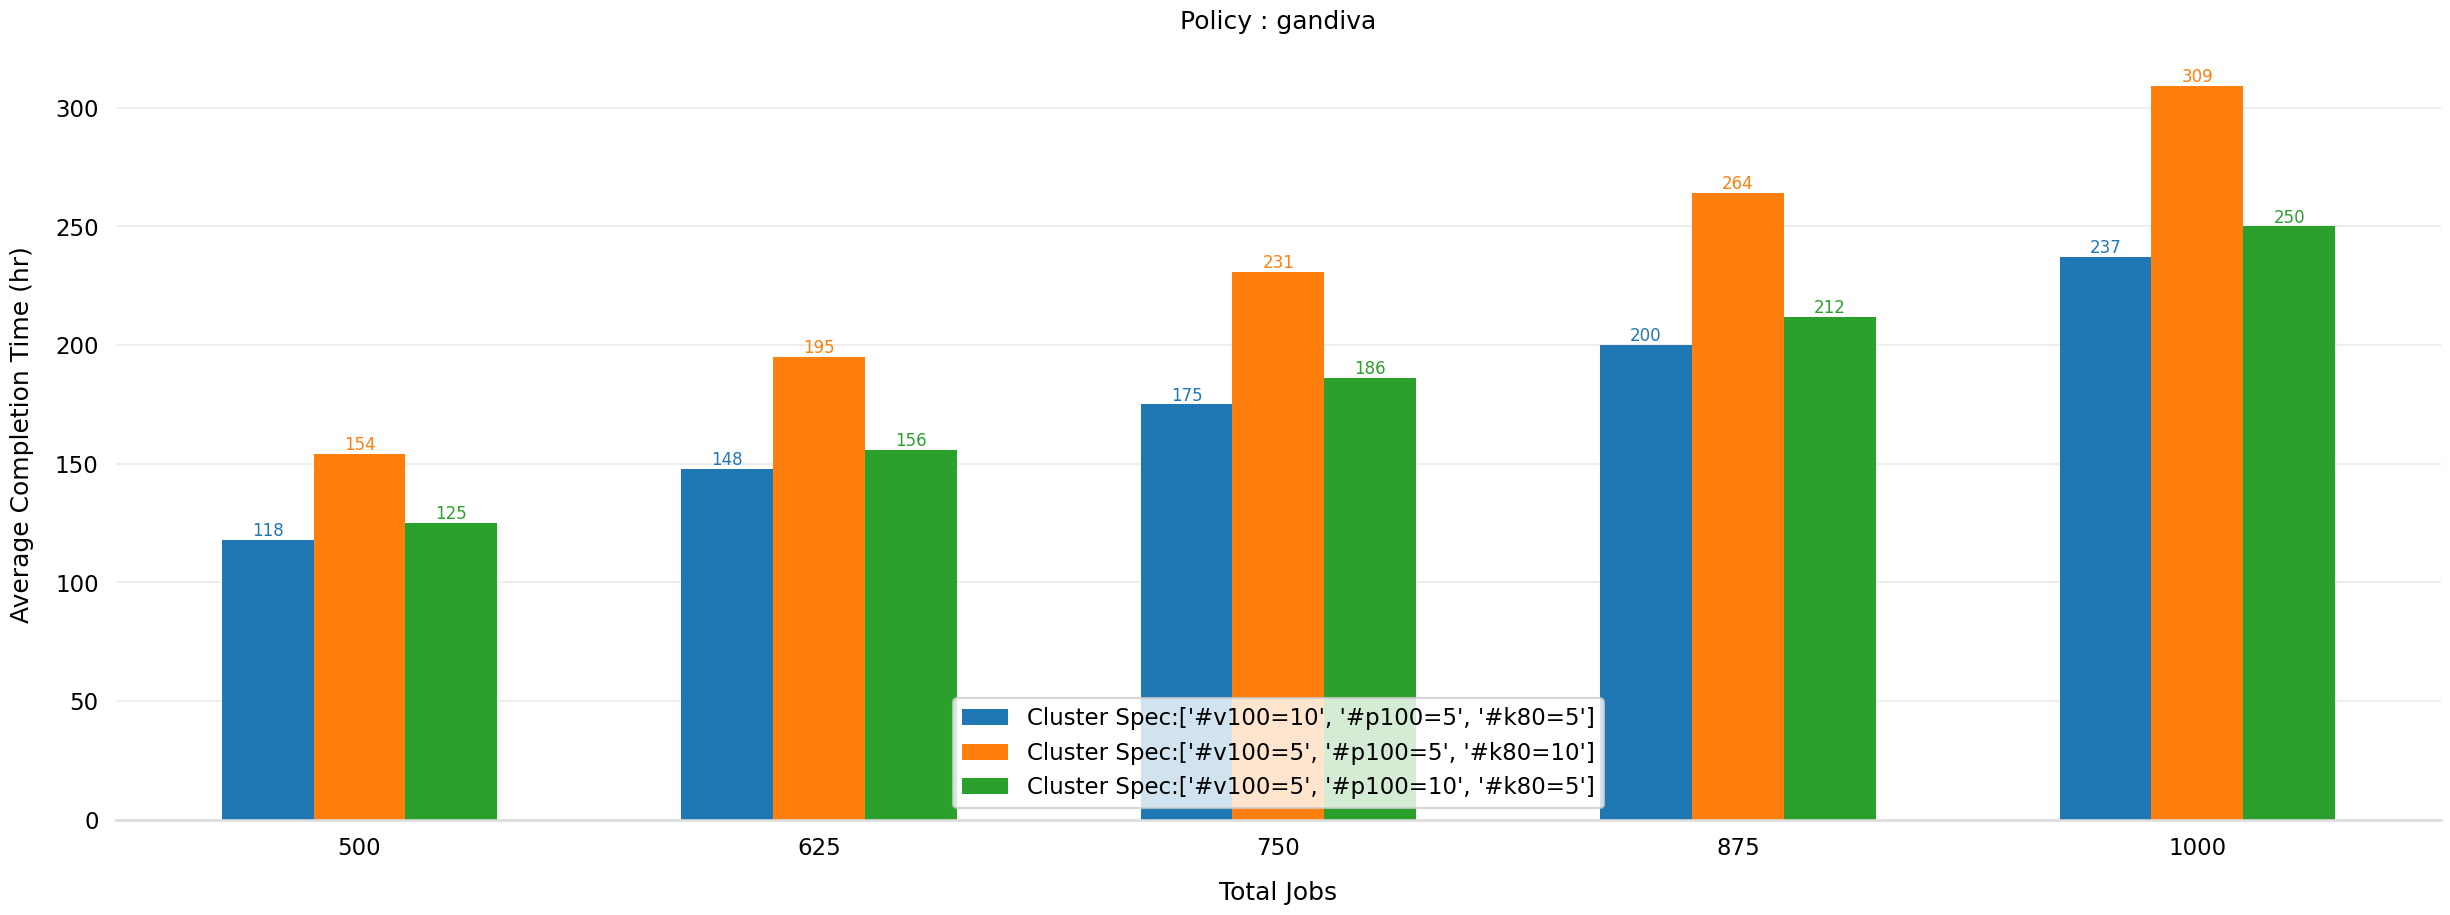

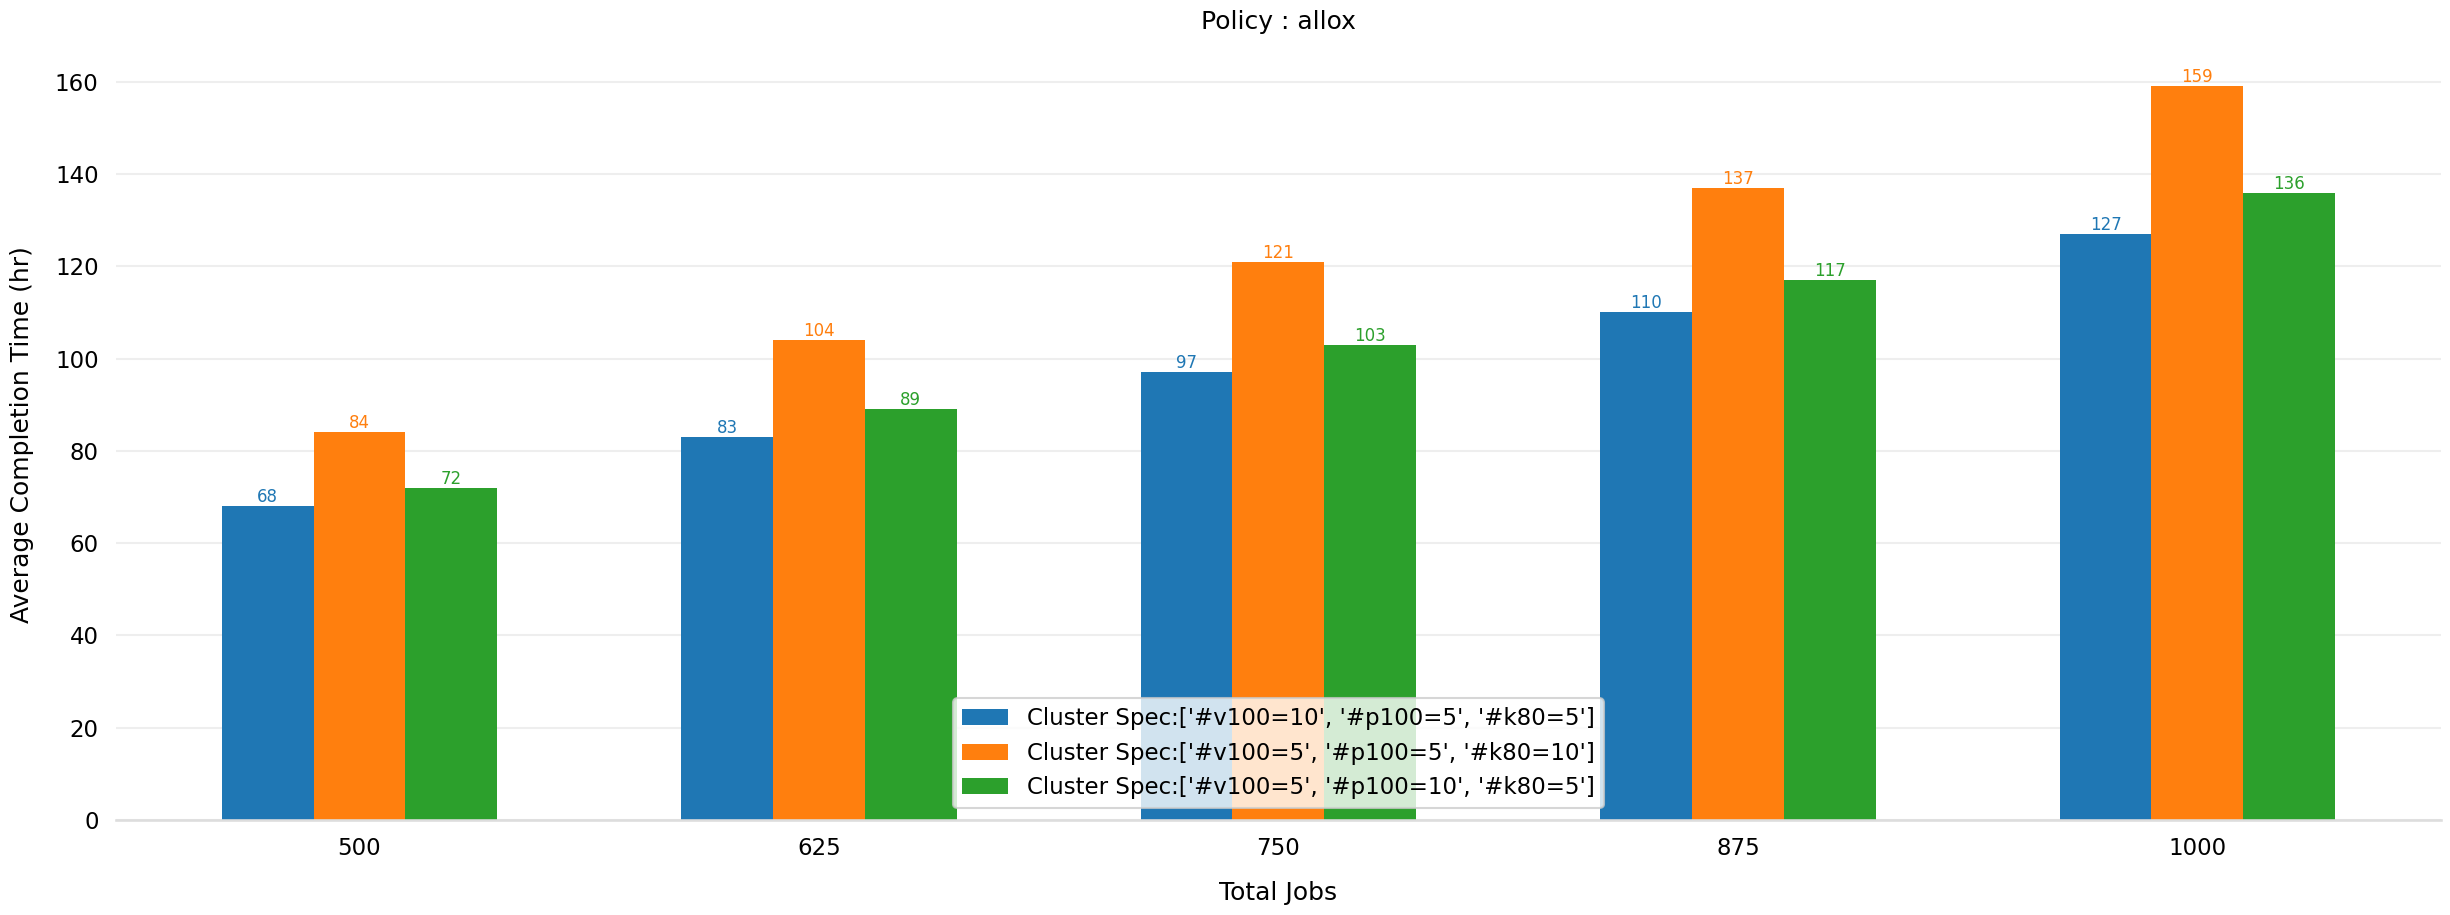

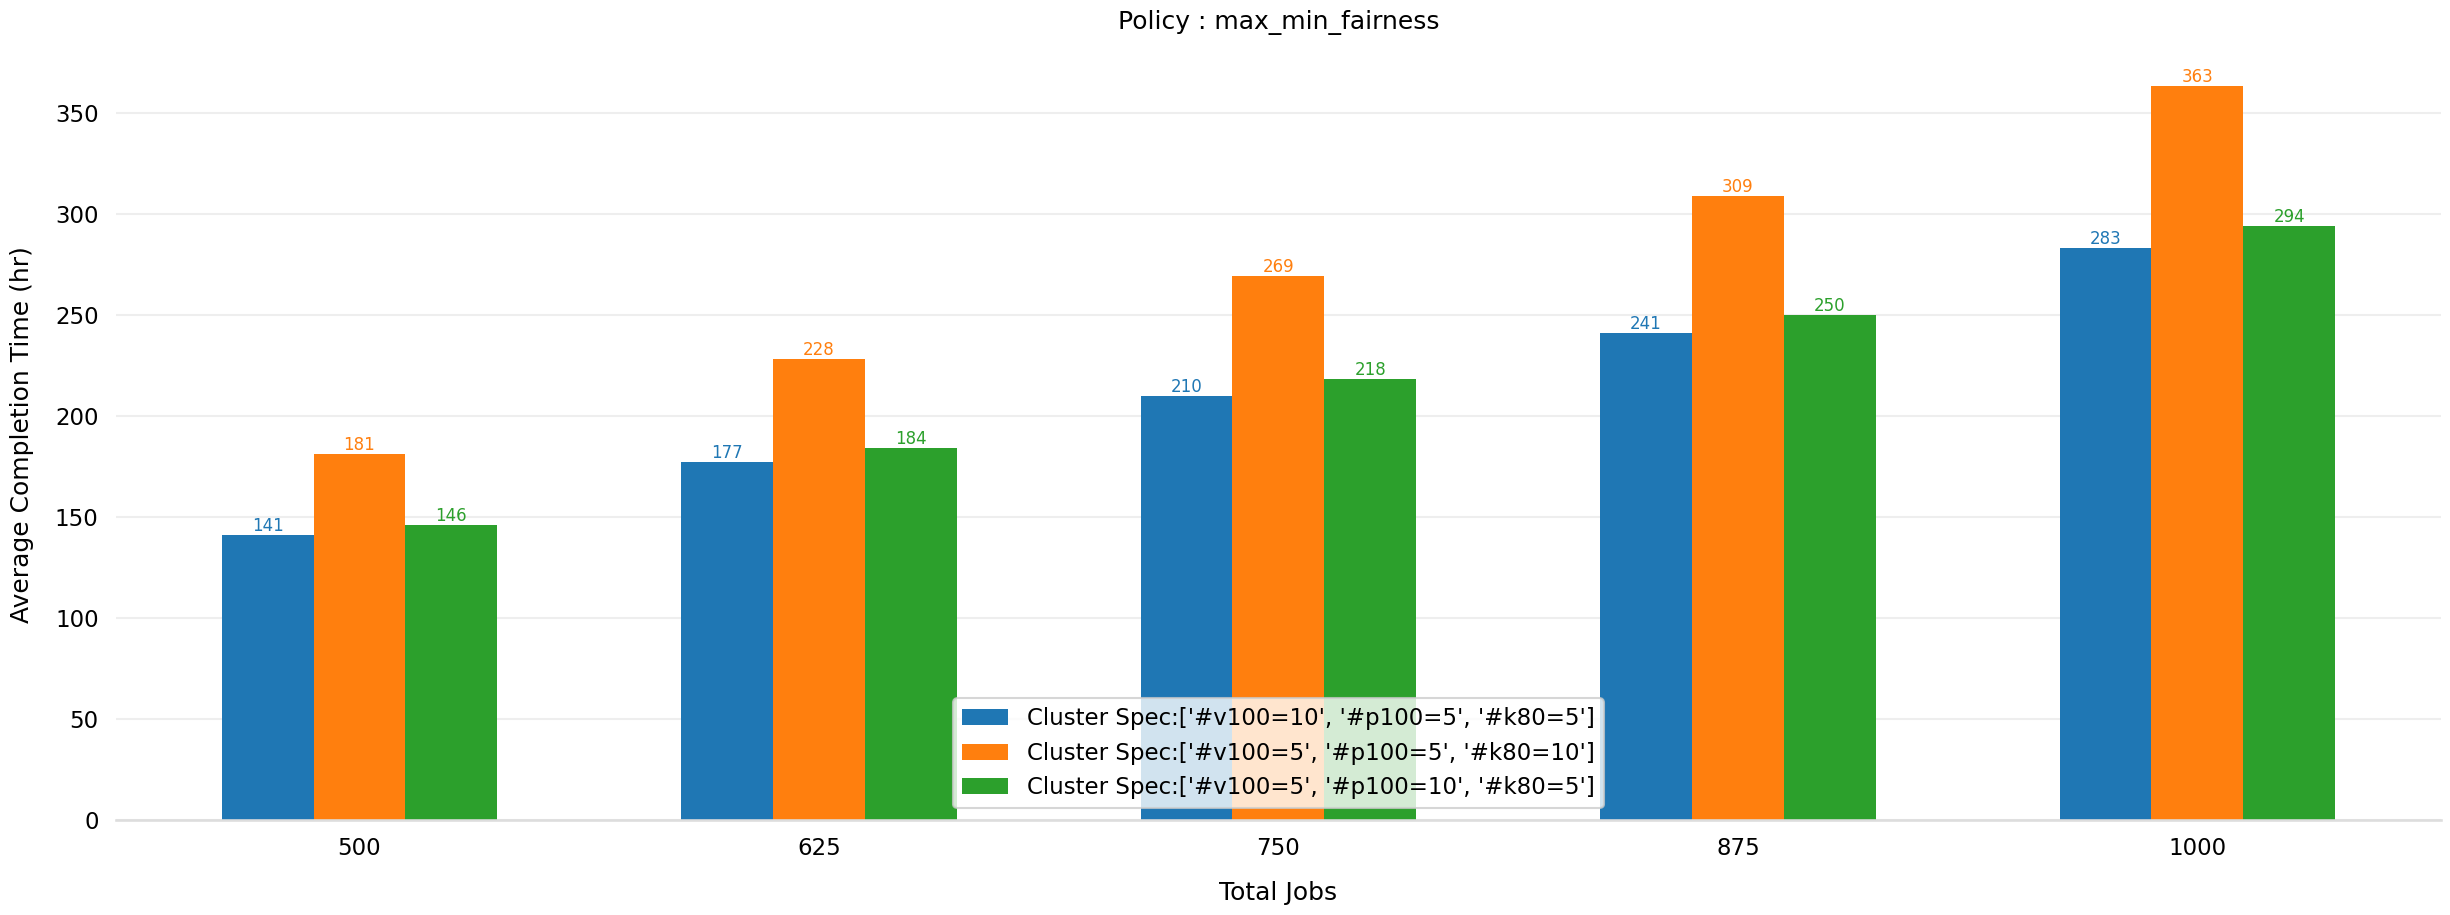

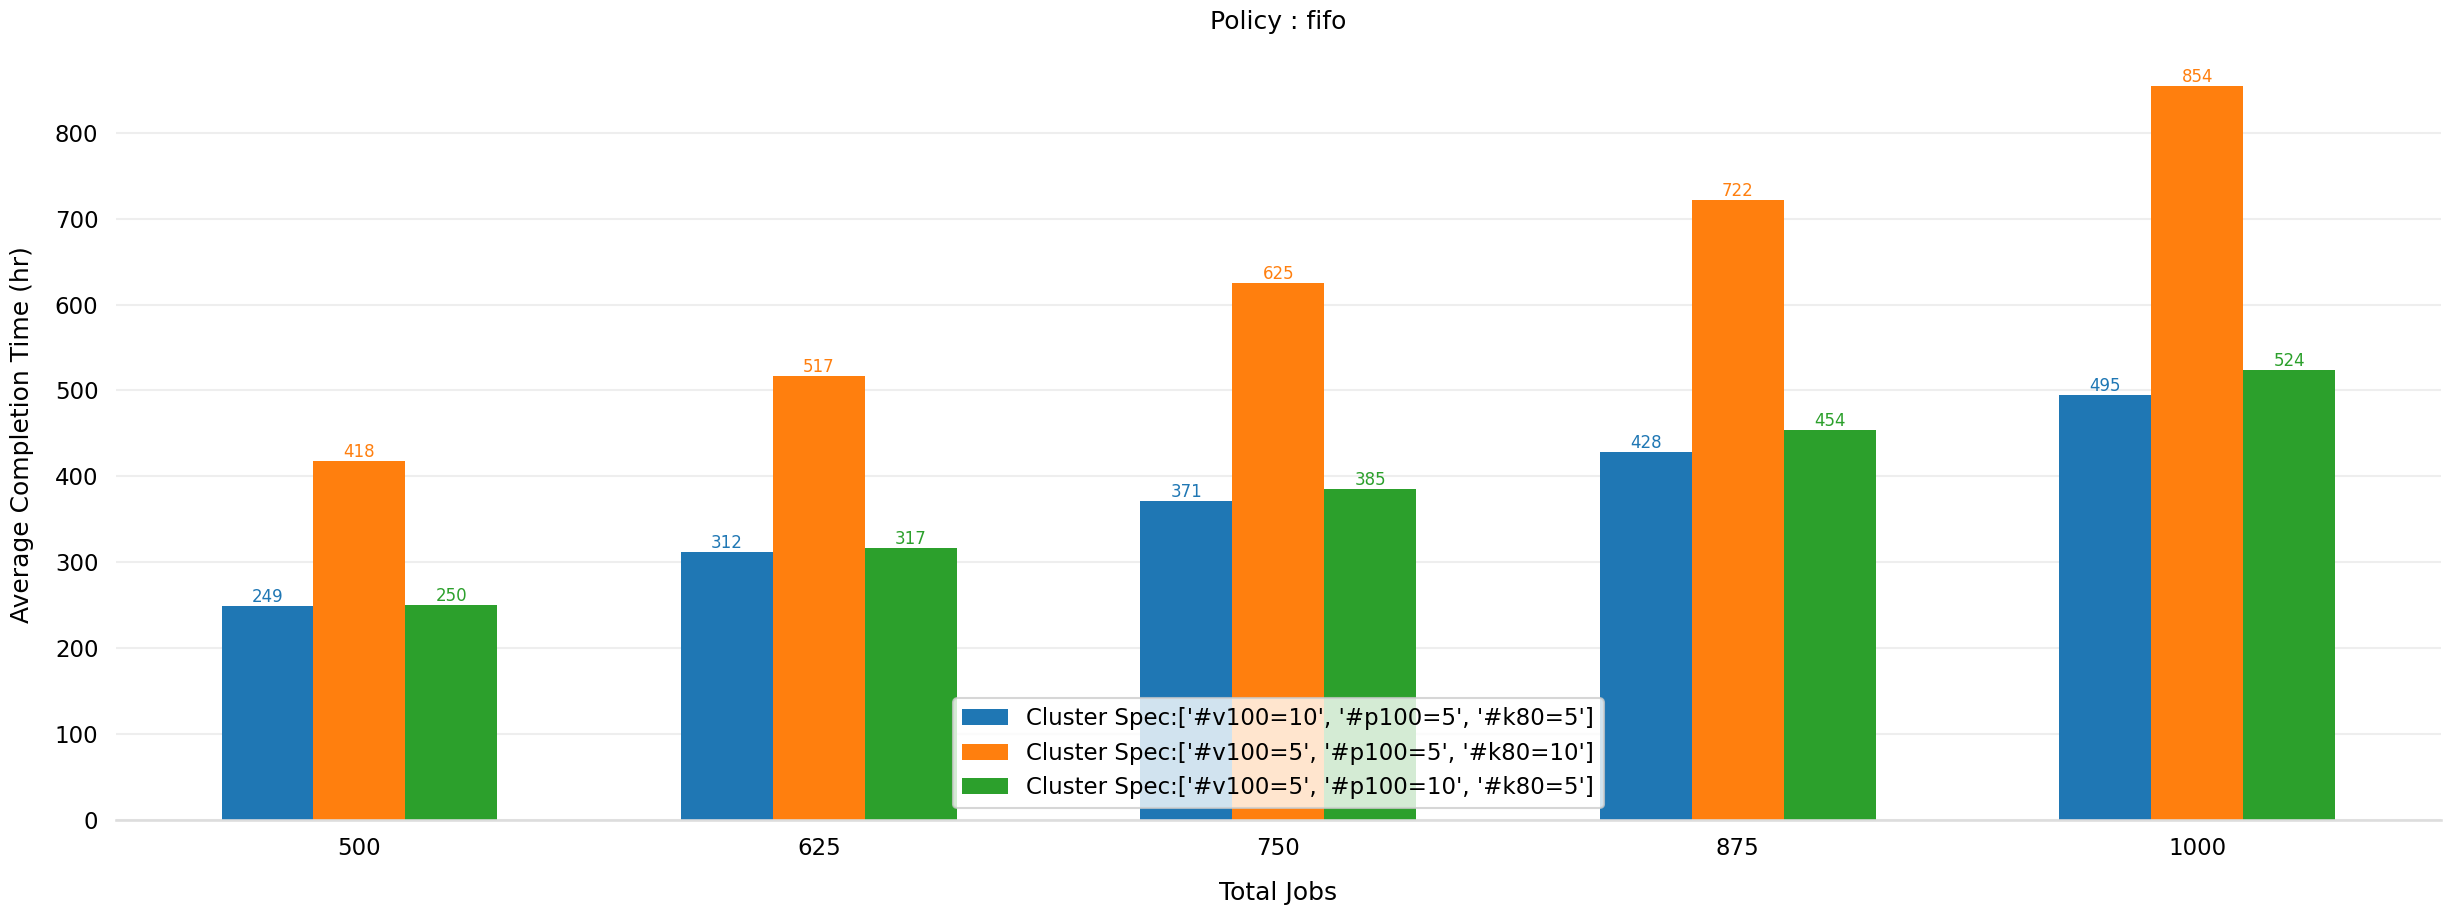

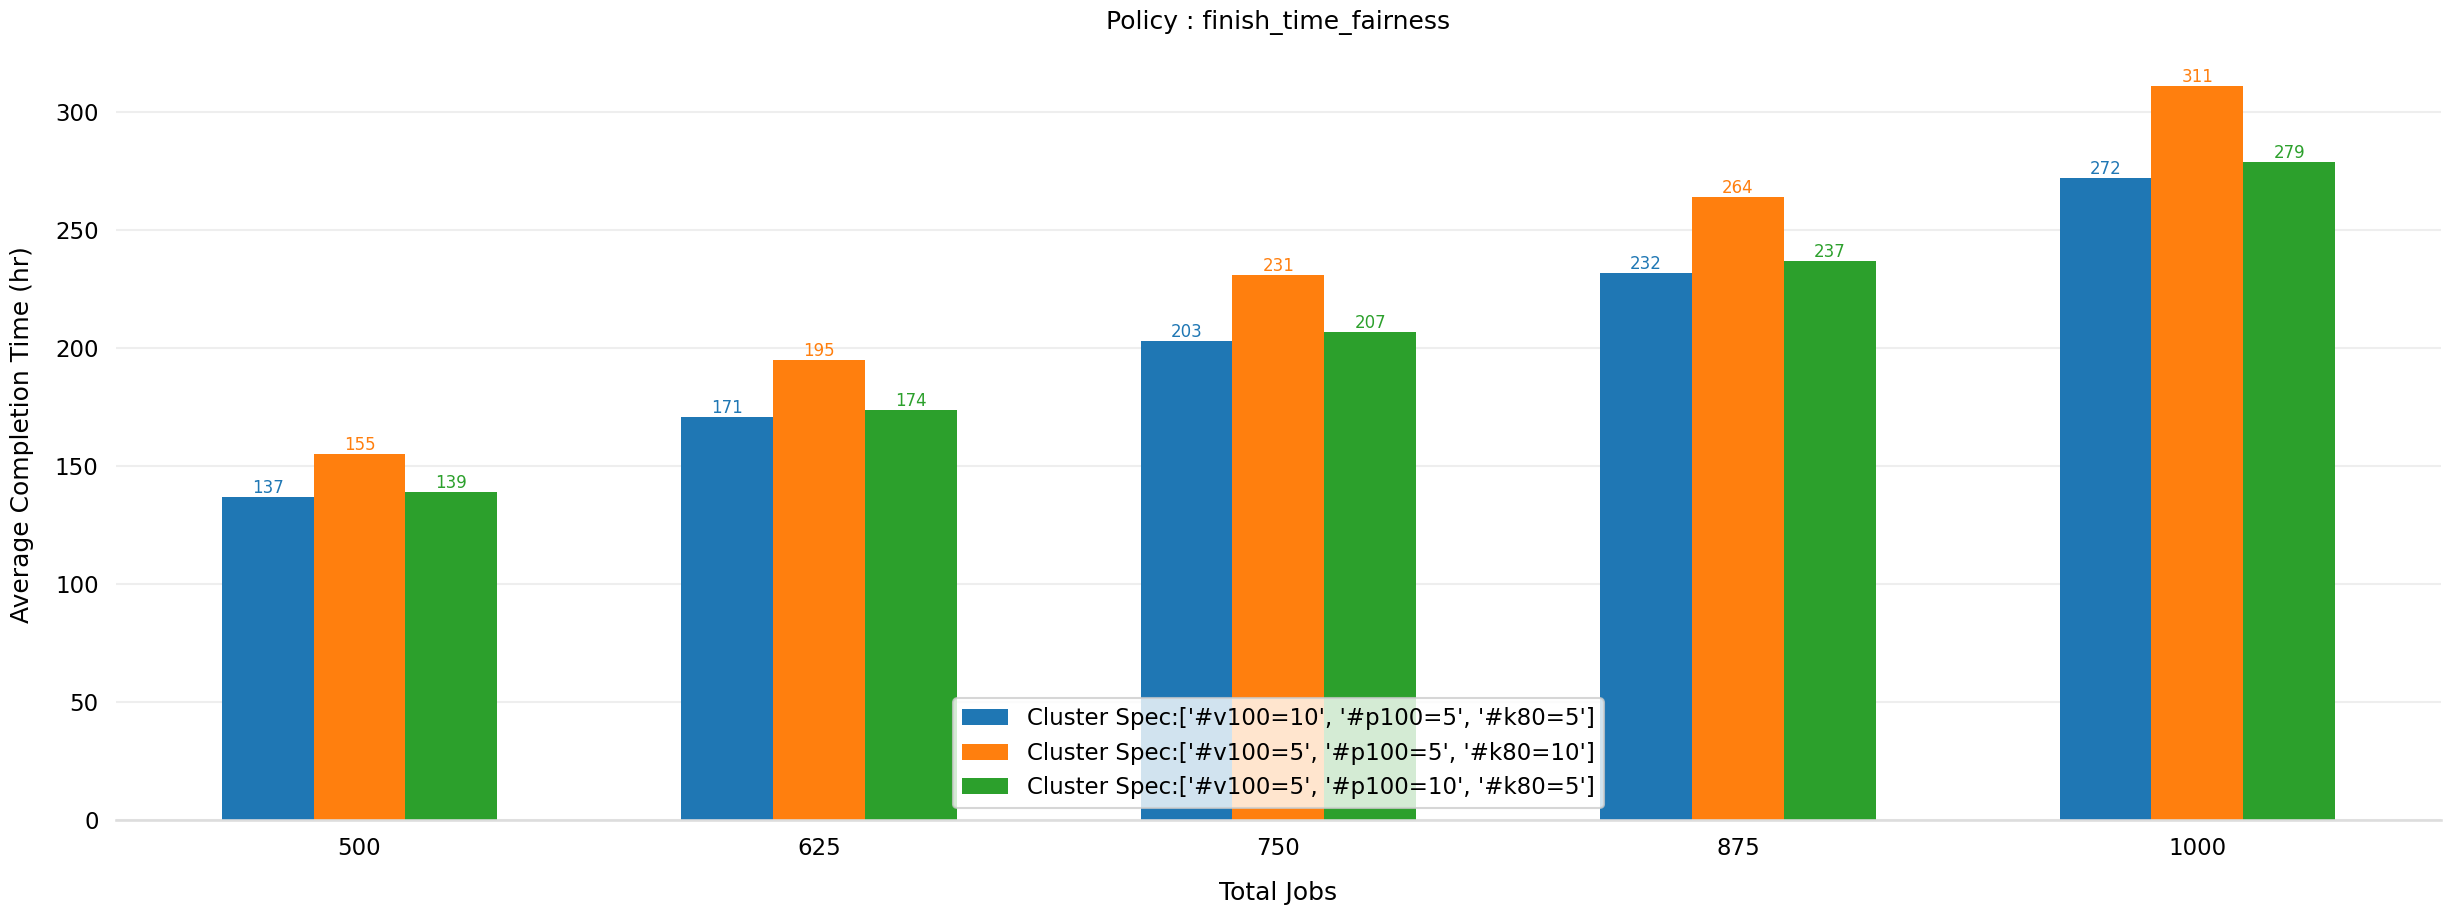

In [4]:
for policy in df_static["policy"].unique():
    result_int = df_static.query(f'policy == "{policy}"')
    
    no_graphs = len(result_int["cluster_spec"].unique())
    fig, ax = plt.subplots(figsize=(30,10))
    bar_width = 0.2

    for idx, cluster_spec in enumerate(result_int["cluster_spec"].unique()):
        result_int2 = result_int.query(f'cluster_spec == "{cluster_spec}"')
        completion_time = []

        for lam in result_int2["total_jobs"].unique():
            result_int3 = result_int2[result_int2["total_jobs"] == lam]
            avg_completion_time = int(sum([(float(r.strip().split(" ")[0])/3600.0) for r in result_int3["average_completion_time"]]) / 3.0)
            completion_time.append((lam, cluster_spec, avg_completion_time))
        
        completion_time.sort()

        x = np.arange(len(completion_time))
        y = [x[2] for x in completion_time]

        x_labels = [x[0] for x in completion_time]

        cluster_details = cluster_spec.split(".")
        cluster_details = [f'#{l}' for l in cluster_details]
        ax.bar(x + (bar_width * idx), y, width=bar_width,label=f'Cluster Spec:{cluster_details}')
        ax.set_xticks(x + (no_graphs - 1) * (bar_width / 2))
        ax.set_xticklabels(x_labels)
        
    ax.legend(loc ="lower center")

    ax.set_xlabel('Total Jobs', labelpad=15)
    ax.set_ylabel('Average Completion Time (hr)', labelpad=15)
    ax.set_title(f'Policy : {policy}', pad=15)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)

    # For each bar in the chart, add a text label.
    for bar in ax.patches:
    # The text annotation for each bar should be its height.
        bar_value = bar.get_height()
        # Format the text with commas to separate thousands. You can do
        # any type of formatting here though.
        text = f'{bar_value:,}'
        # This will give the middle of each bar on the x-axis.
        text_x = bar.get_x() + bar.get_width() / 2
        # get_y() is where the bar starts so we add the height to it.
        text_y = bar.get_y() + bar_value
        # If we want the text to be the same color as the bar, we can
        # get the color like so:
        bar_color = bar.get_facecolor()
        # If you want a consistent color, you can just set it as a constant, e.g. #222222
        ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
                size=12)

cluster utilization based on policies for each cluster spec with varying lambda values averaged over seeds

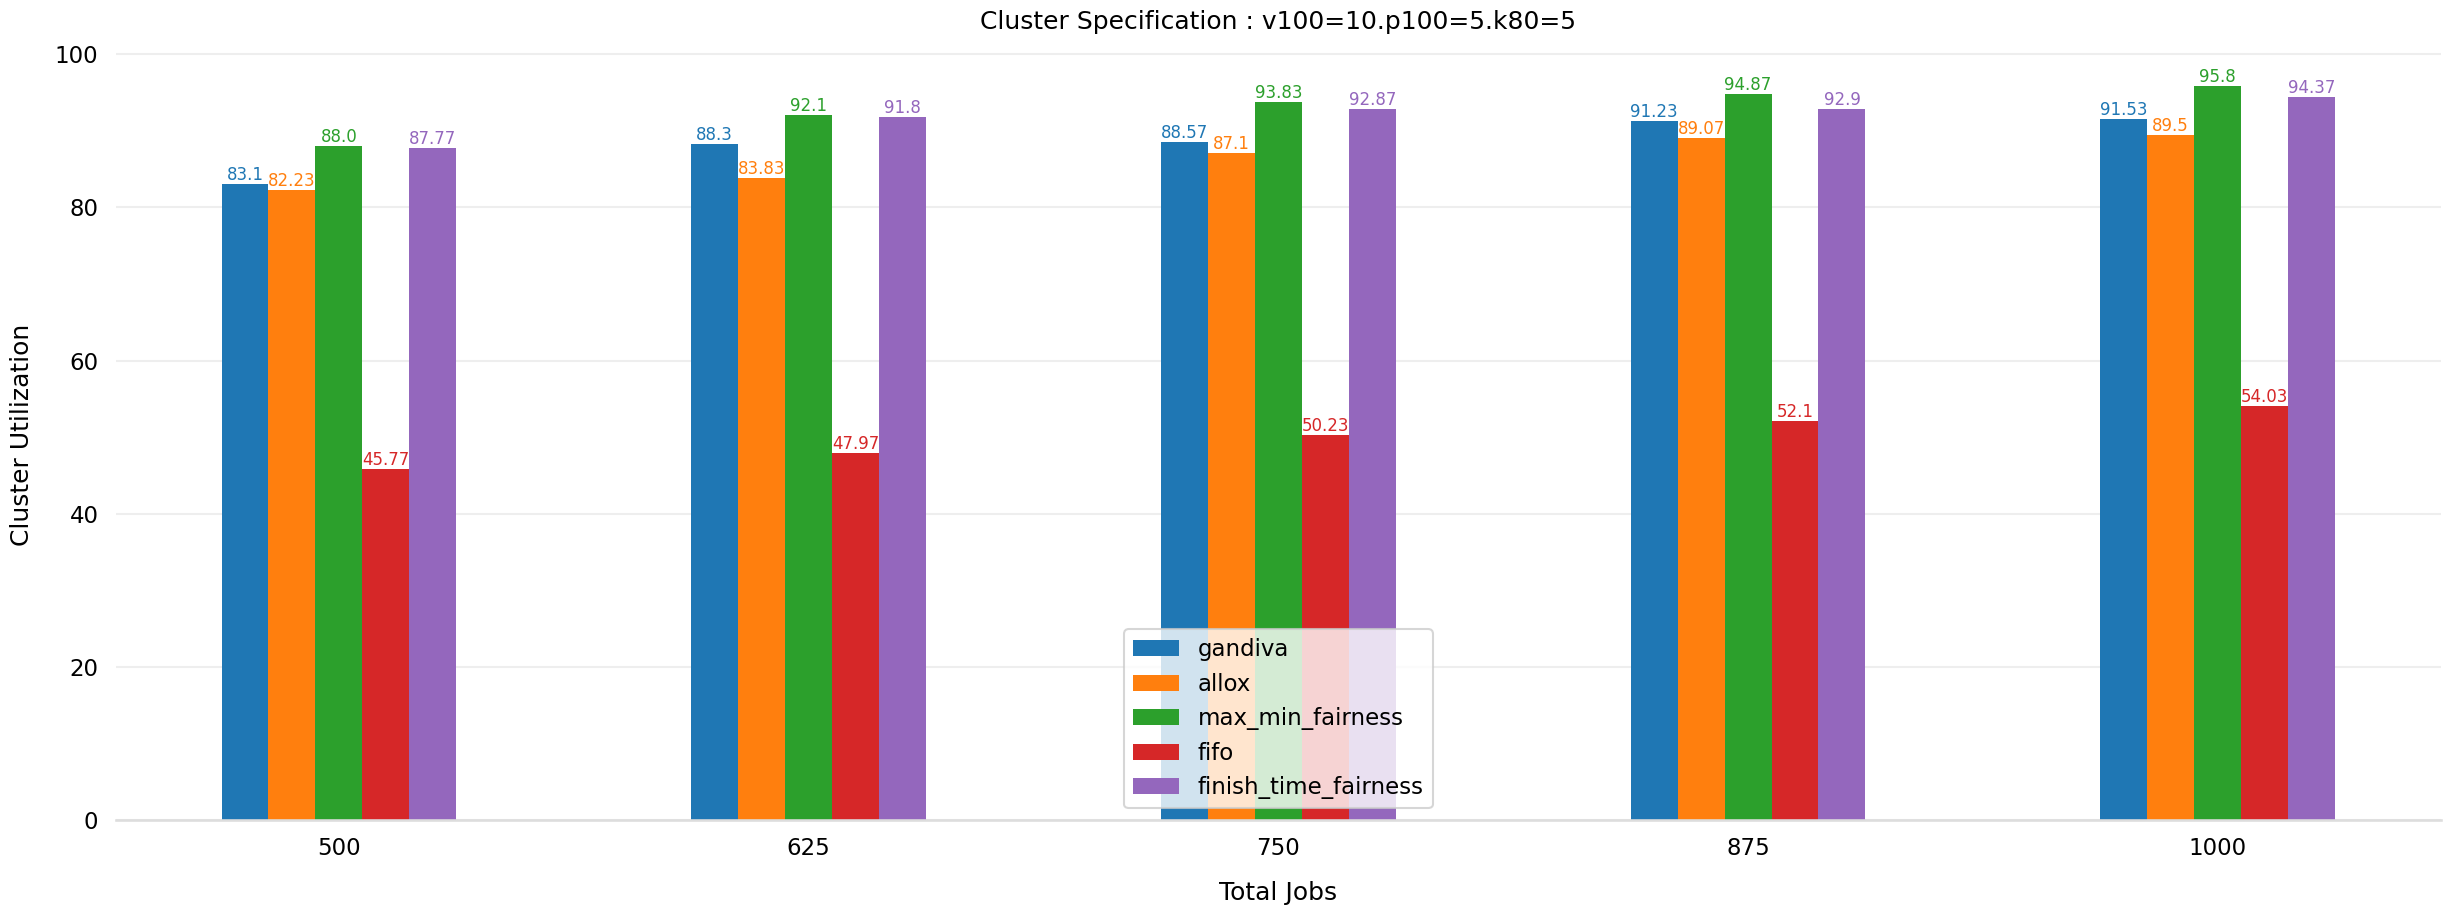

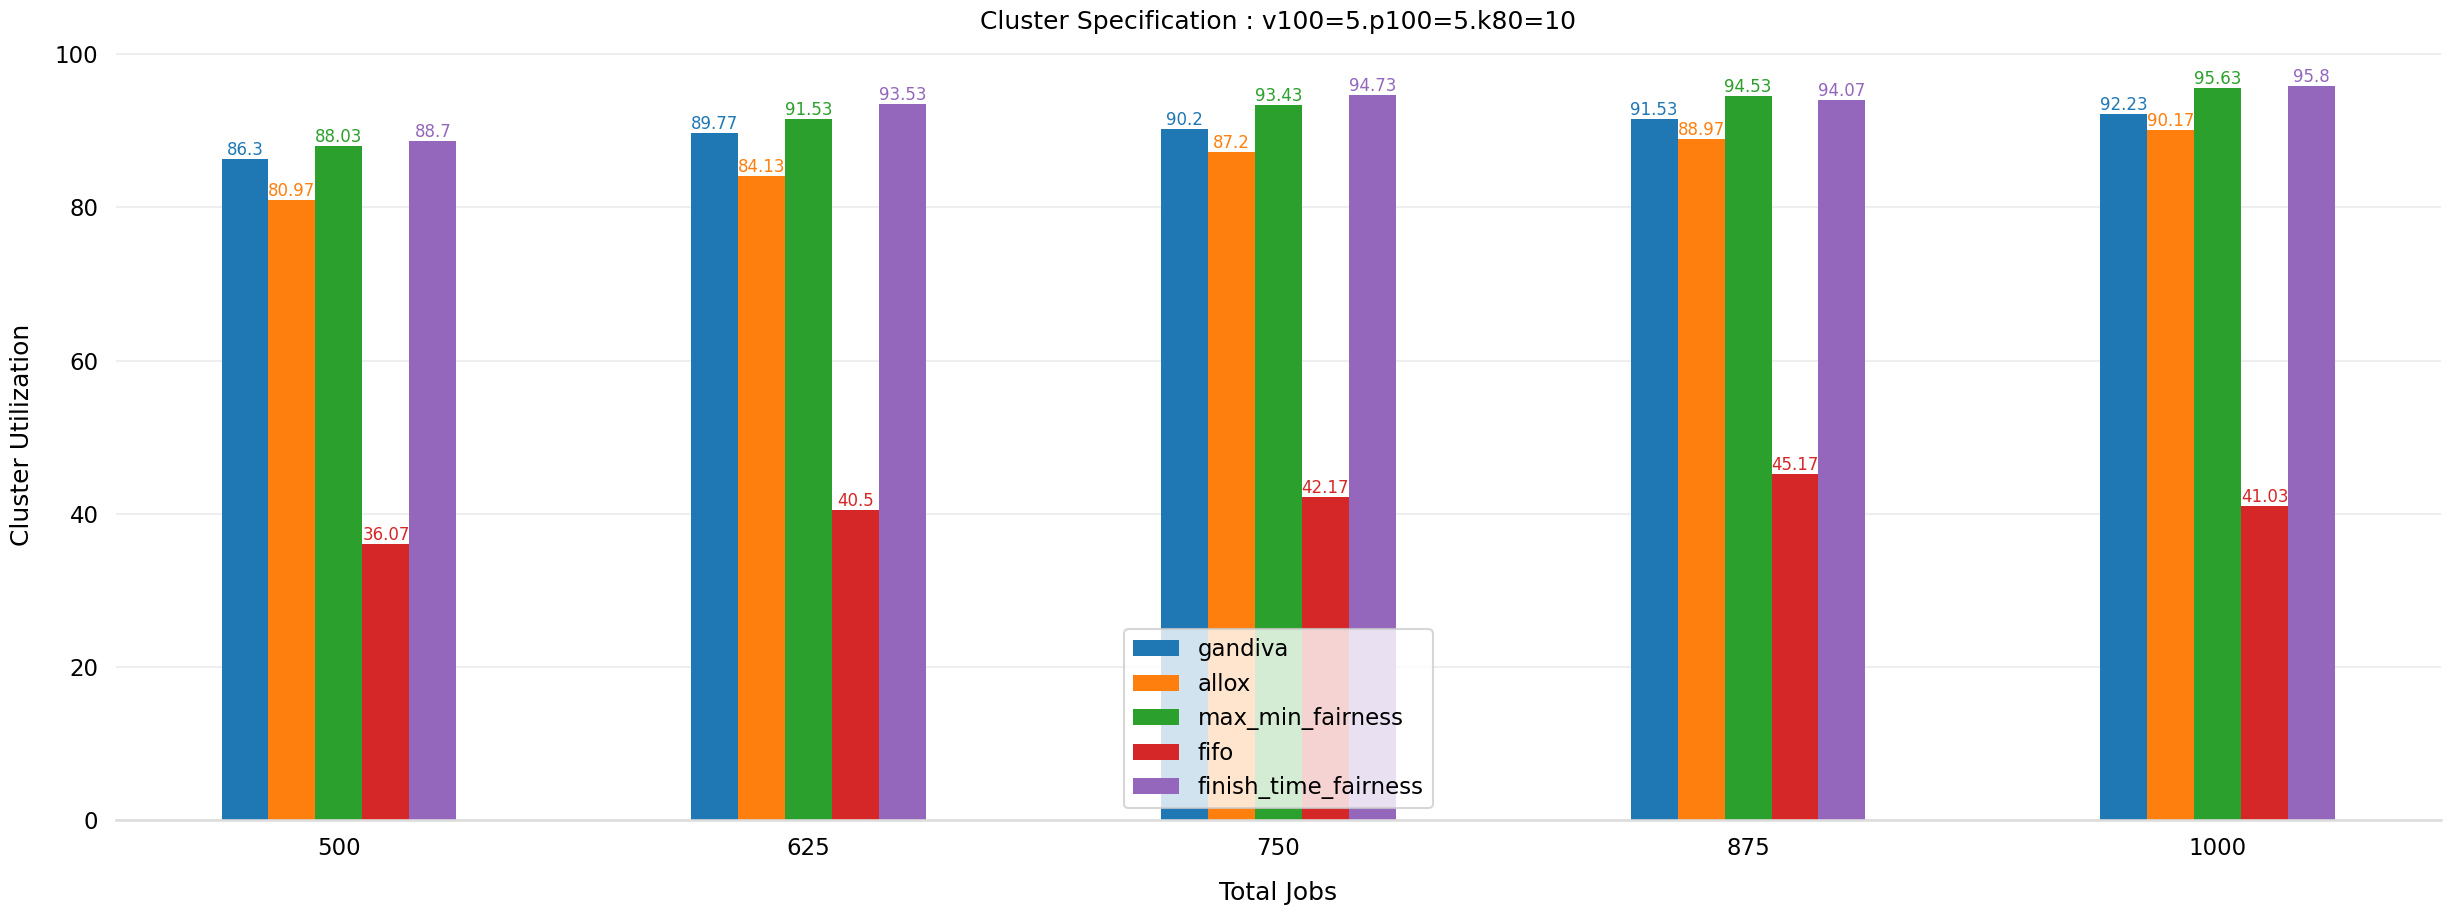

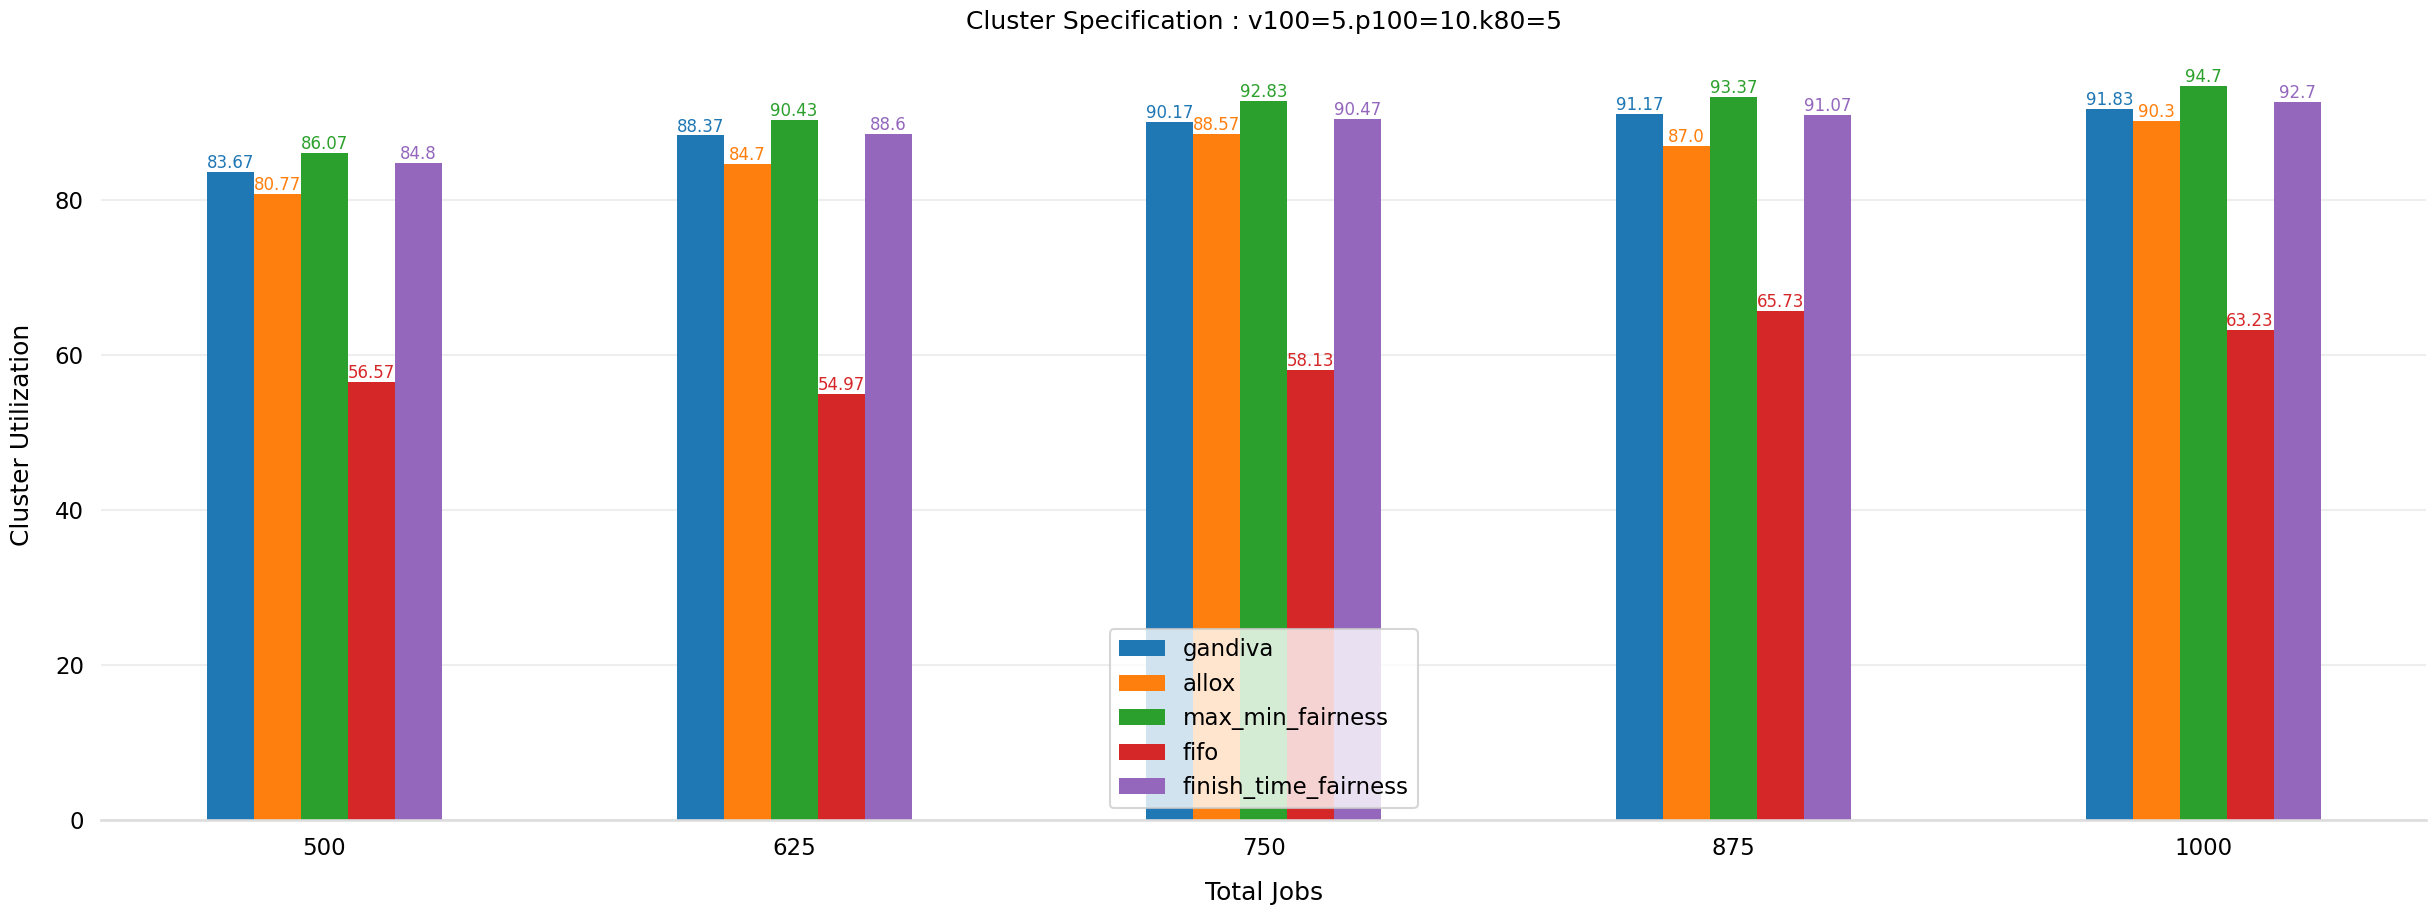

In [5]:
for cluster_spec in df_static["cluster_spec"].unique():
    result_int = df_static.query(f'cluster_spec == "{cluster_spec}"')
    
    no_graphs = len(result_int["policy"].unique())
    fig, ax = plt.subplots(figsize=(30,10))
    bar_width = 0.1

    for idx, policy in enumerate(result_int["policy"].unique()):
        result_int2 = result_int.query(f'policy == "{policy}"')
        utilization = []

        for lam in result_int2["total_jobs"].unique():
            result_int3 = result_int2[result_int2["total_jobs"] == lam]
            utilization.append((lam, cluster_spec, round(float(result_int3["utilization"].mean() * 100),2)))
        
        utilization.sort()

        x = np.arange(len(utilization))
        y = [x[2] for x in utilization]

        x_labels = [x[0] for x in utilization]

        cluster_details = cluster_spec.split(".")
        cluster_details = [f'#{l}' for l in cluster_details]
        ax.bar(x + (bar_width * idx), y, width=bar_width,label=f'{policy}')
        ax.set_xticks(x + (no_graphs - 1) * (bar_width / 2))
        ax.set_xticklabels(x_labels)
        
    ax.legend(loc ="lower center")

    ax.set_xlabel('Total Jobs', labelpad=15)
    ax.set_ylabel('Cluster Utilization', labelpad=15)
    ax.set_title(f'Cluster Specification : {cluster_spec}', pad=15)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)

    # For each bar in the chart, add a text label.
    for bar in ax.patches:
    # The text annotation for each bar should be its height.
        bar_value = bar.get_height()
        # Format the text with commas to separate thousands. You can do
        # any type of formatting here though.
        text = f'{bar_value:,}'
        # This will give the middle of each bar on the x-axis.
        text_x = bar.get_x() + bar.get_width() / 2
        # get_y() is where the bar starts so we add the height to it.
        text_y = bar.get_y() + bar_value
        # If we want the text to be the same color as the bar, we can
        # get the color like so:
        bar_color = bar.get_facecolor()
        # If you want a consistent color, you can just set it as a constant, e.g. #222222
        ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
                size=12)

average completion time based on policies for each cluster spec with varying lambda values averaged over seeds

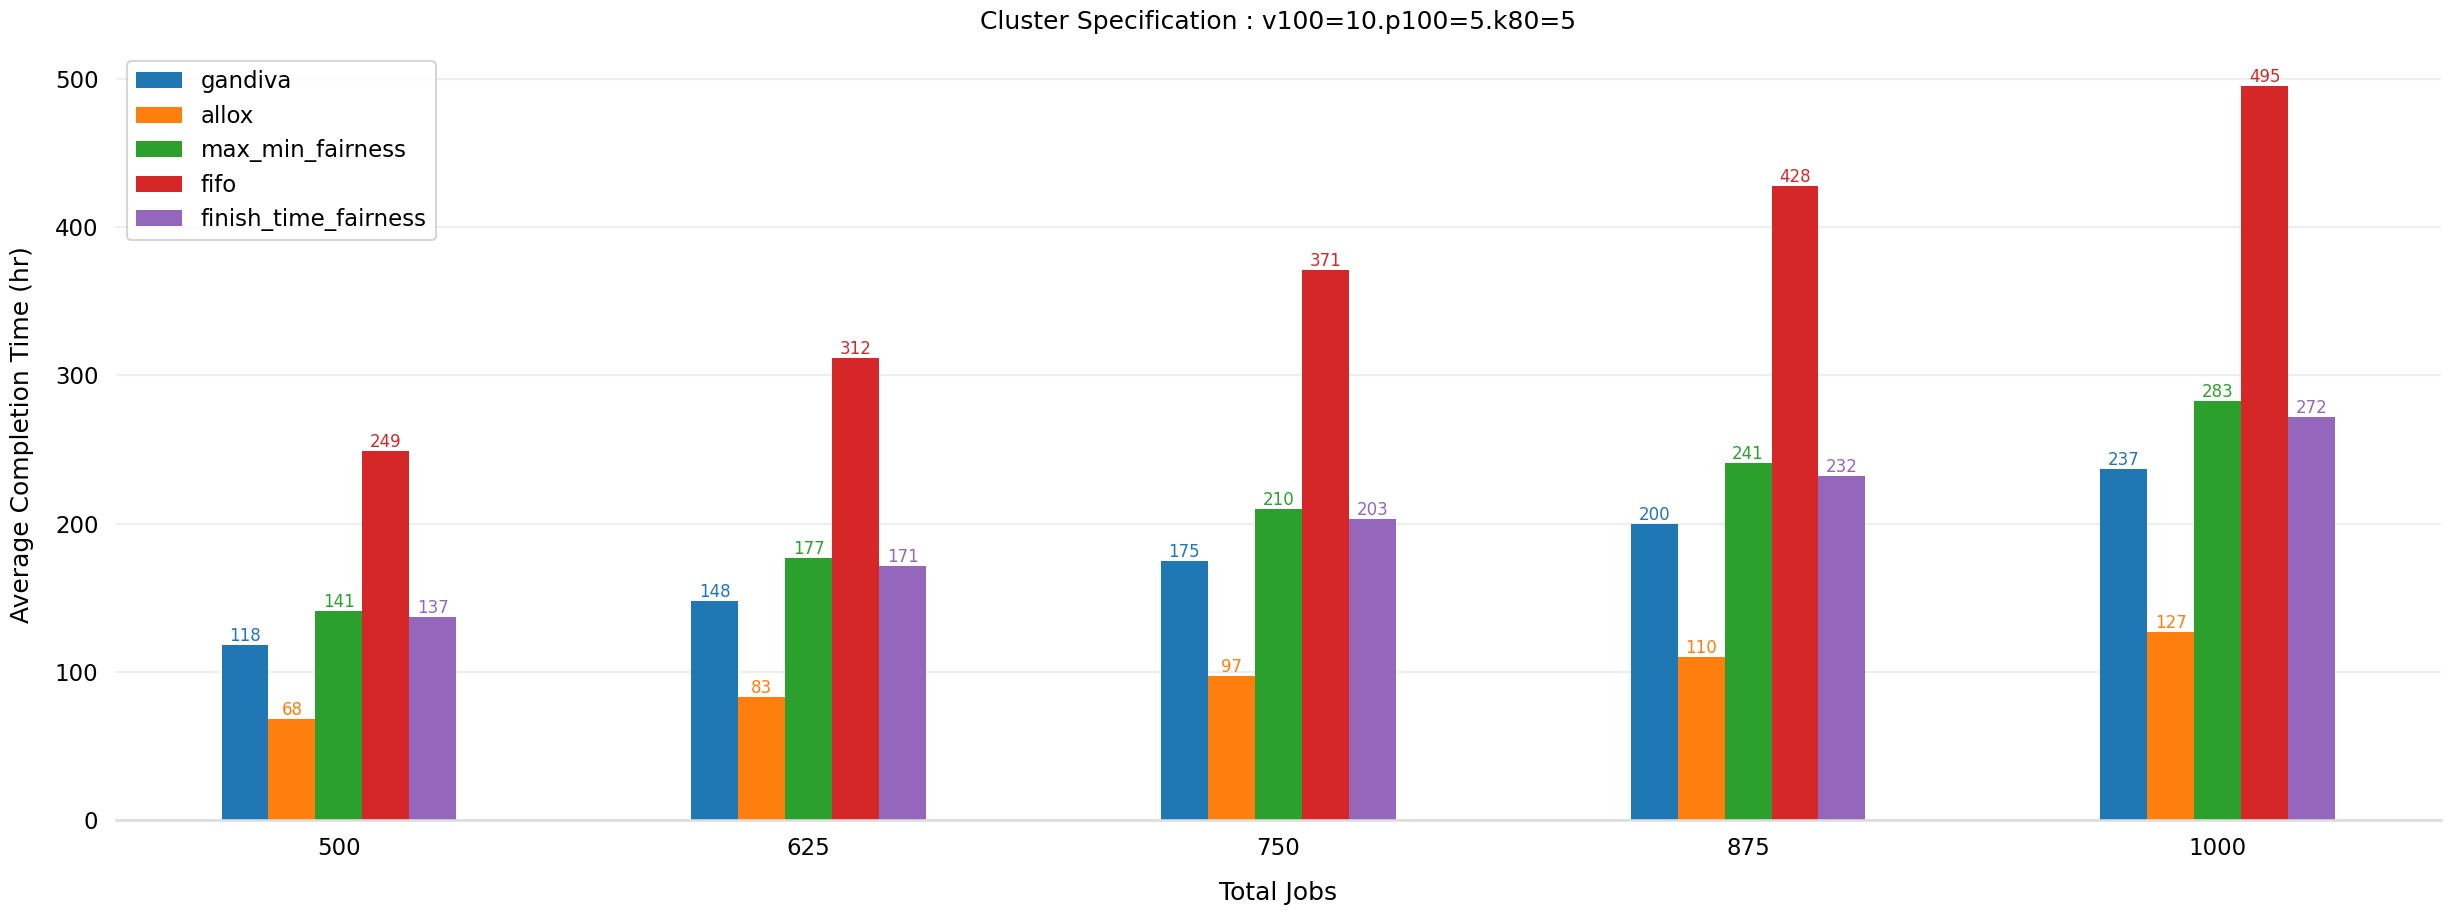

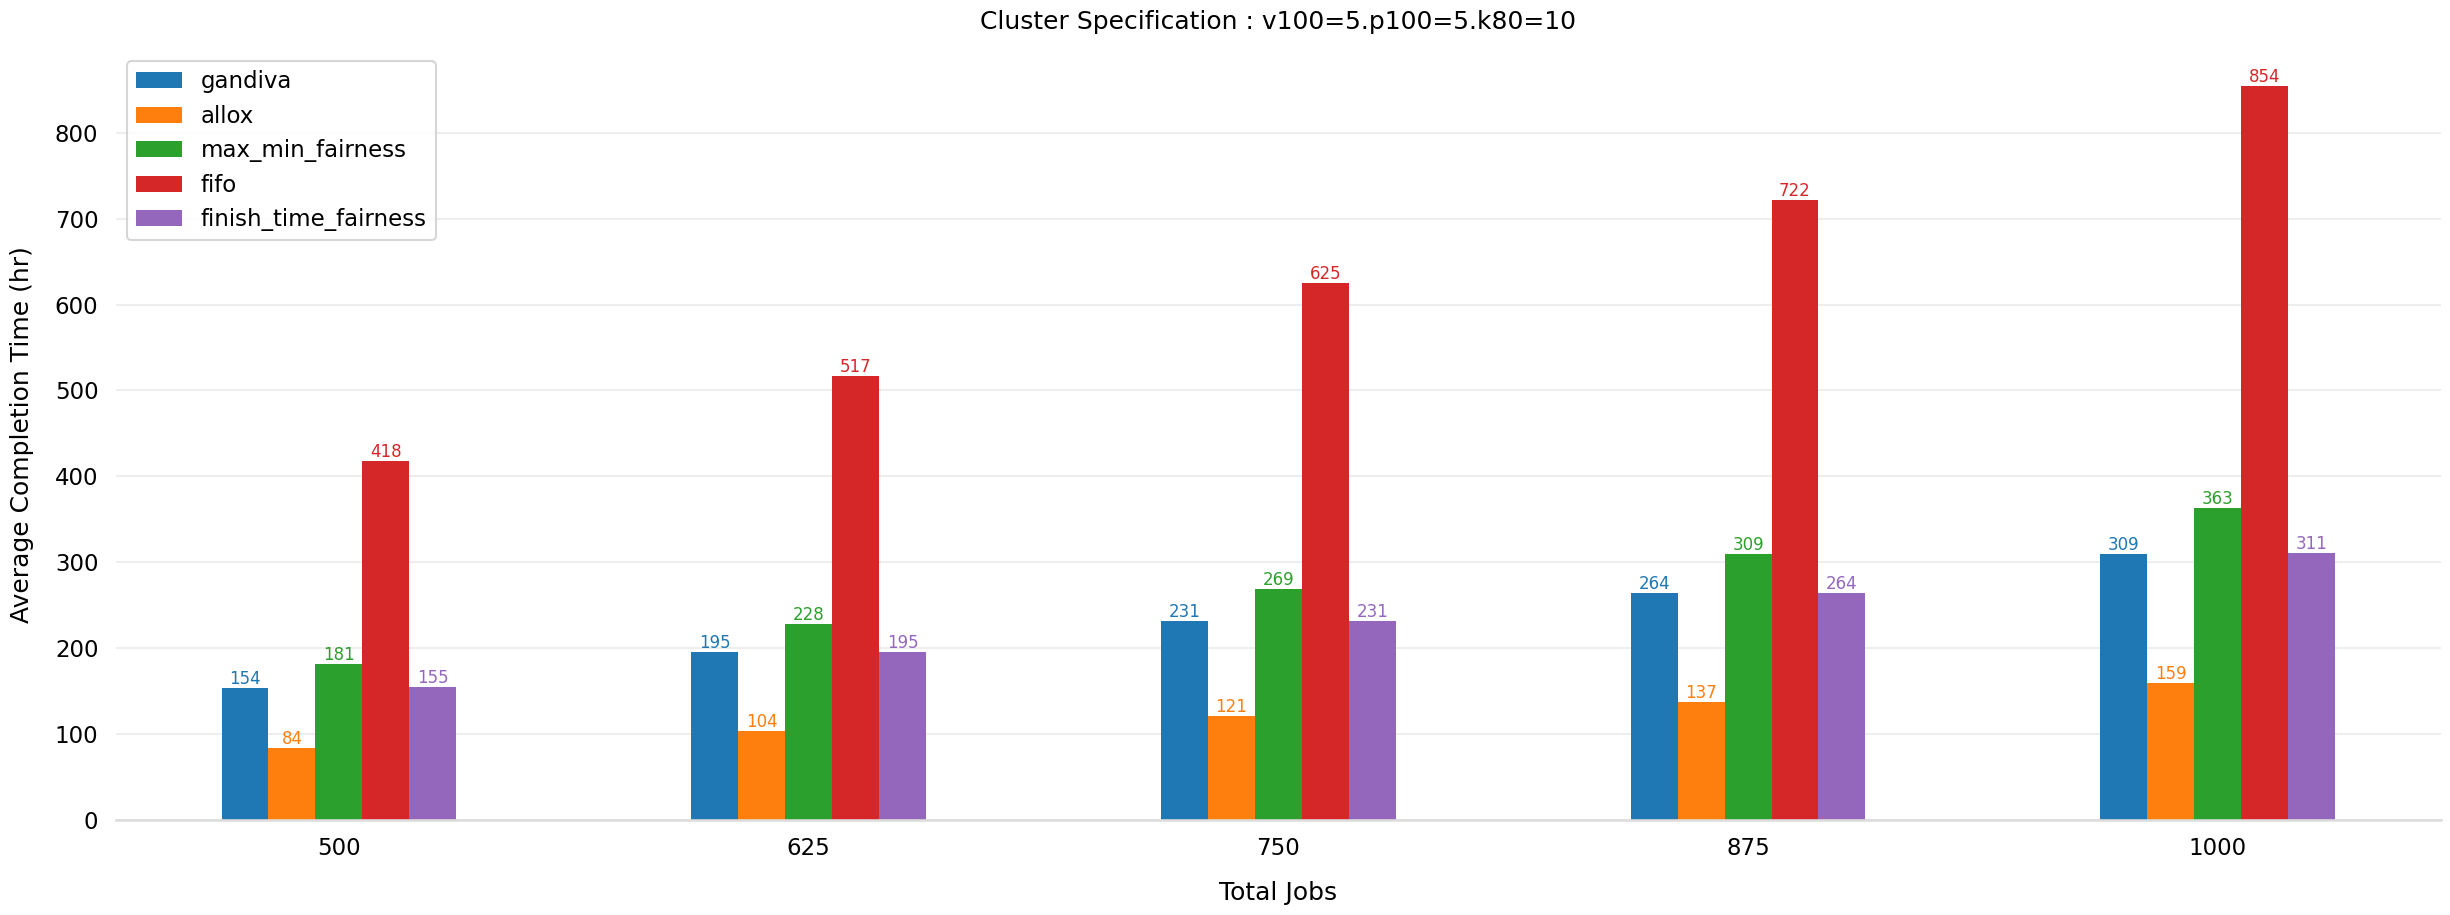

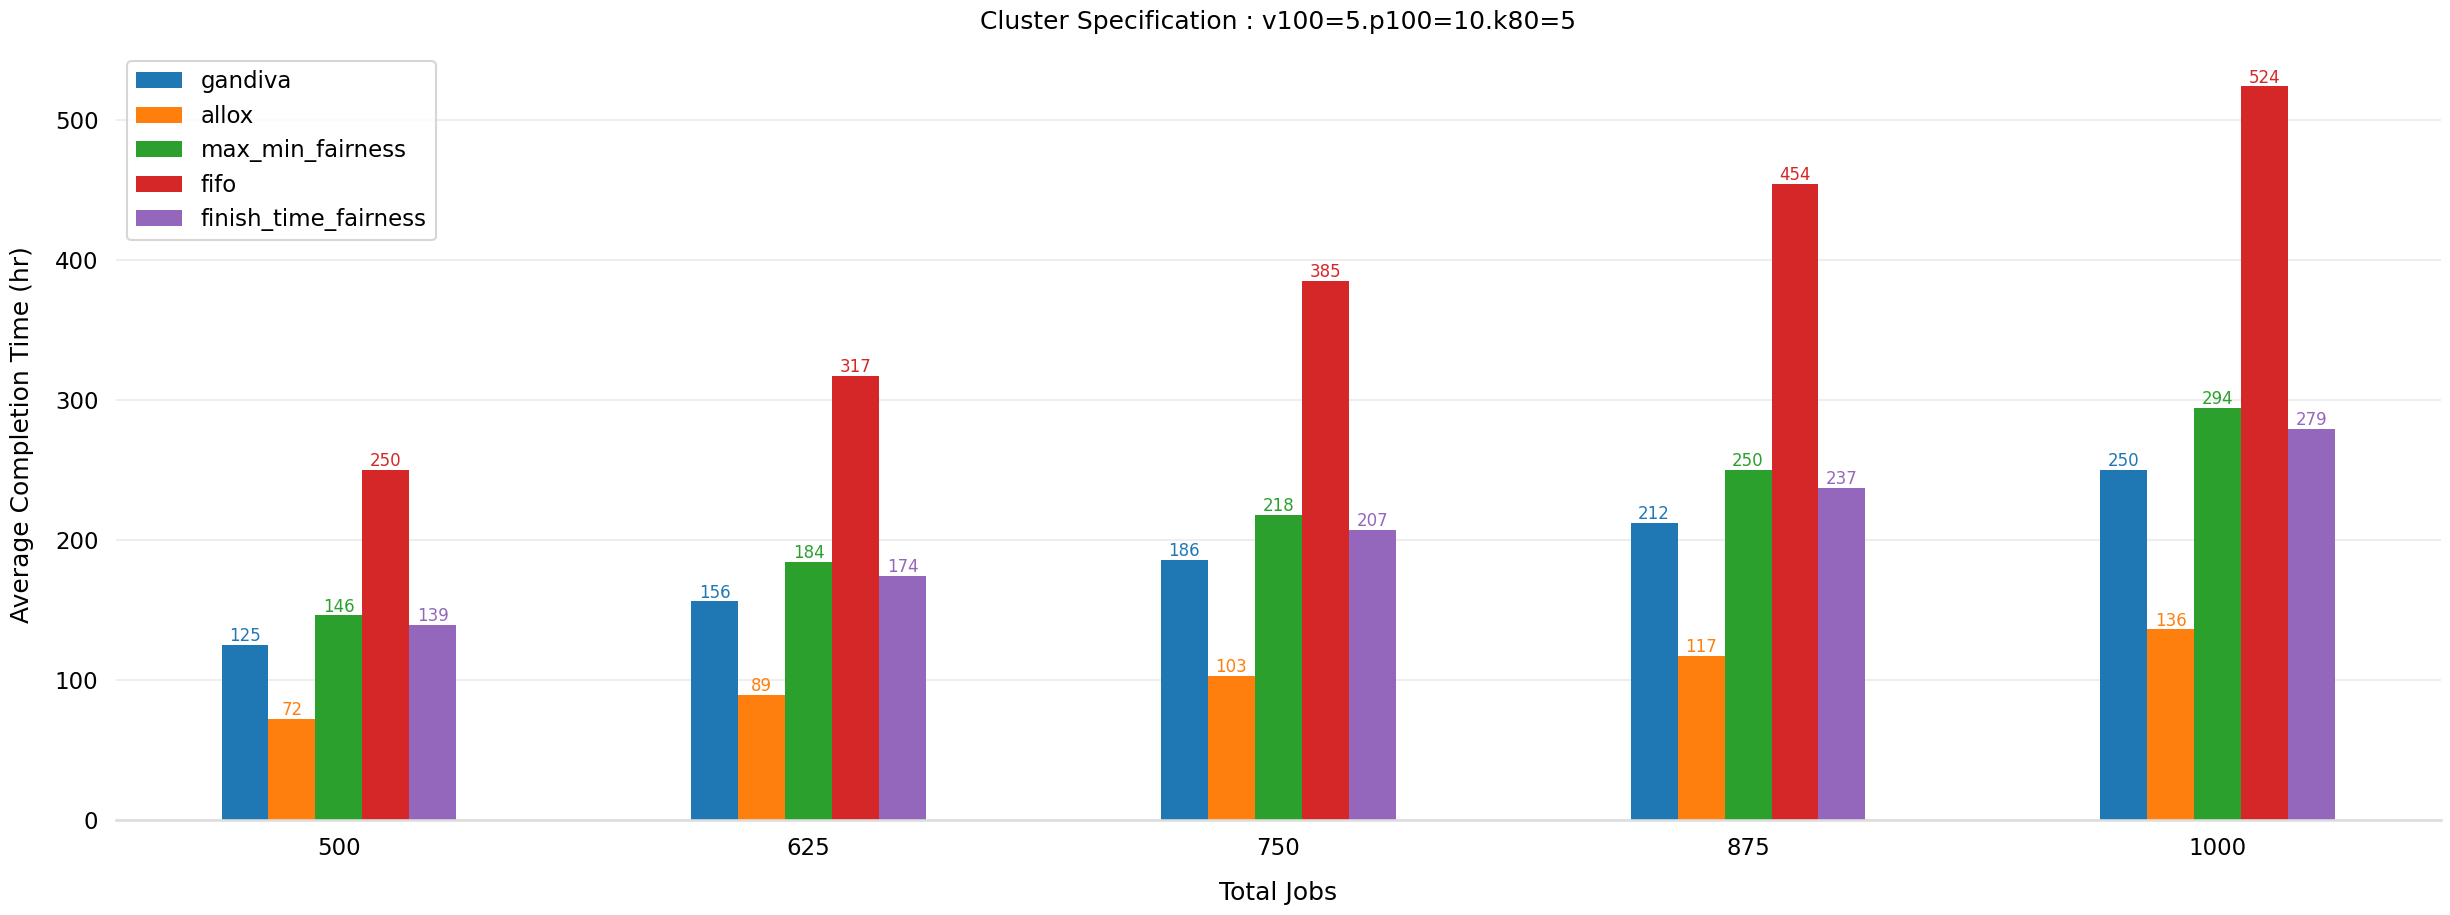

In [6]:
for cluster_spec in df_static["cluster_spec"].unique():
    result_int = df_static.query(f'cluster_spec == "{cluster_spec}"')
    
    no_graphs = len(result_int["policy"].unique())
    fig, ax = plt.subplots(figsize=(30,10))
    bar_width = 0.1

    for idx, policy in enumerate(result_int["policy"].unique()):
        result_int2 = result_int.query(f'policy == "{policy}"')
        completion_time = []

        for lam in result_int2["total_jobs"].unique():
            result_int3 = result_int2[result_int2["total_jobs"] == lam]
            avg_completion_time = int(sum([(float(r.strip().split(" ")[0])/3600.0) for r in result_int3["average_completion_time"]]) / 3.0)
            completion_time.append((lam, cluster_spec, avg_completion_time))
        
        completion_time.sort()

        x = np.arange(len(completion_time))
        y = [x[2] for x in completion_time]

        x_labels = [x[0] for x in completion_time]

        cluster_details = cluster_spec.split(".")
        cluster_details = [f'#{l}' for l in cluster_details]
        ax.bar(x + (bar_width * idx), y, width=bar_width,label=f'{policy}')
        ax.set_xticks(x + (no_graphs - 1) * (bar_width / 2))
        ax.set_xticklabels(x_labels)
        
    ax.legend(loc ="upper left")

    ax.set_xlabel('Total Jobs', labelpad=15)
    ax.set_ylabel('Average Completion Time (hr)', labelpad=15)
    ax.set_title(f'Cluster Specification : {cluster_spec}', pad=15)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)

    # For each bar in the chart, add a text label.
    for bar in ax.patches:
    # The text annotation for each bar should be its height.
        bar_value = bar.get_height()
        # Format the text with commas to separate thousands. You can do
        # any type of formatting here though.
        text = f'{bar_value:,}'
        # This will give the middle of each bar on the x-axis.
        text_x = bar.get_x() + bar.get_width() / 2
        # get_y() is where the bar starts so we add the height to it.
        text_y = bar.get_y() + bar_value
        # If we want the text to be the same color as the bar, we can
        # get the color like so:
        bar_color = bar.get_facecolor()
        # If you want a consistent color, you can just set it as a constant, e.g. #222222
        ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
                size=12)